### Reproducing results from Bernstein paper
https://arxiv.org/abs/1807.11873

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

In [3]:
#os.cpu_count()

In [4]:
import time
import scipy.stats
import seaborn as sns

from astropy.table import Table, Column
from multiprocessing import Process, Queue, Pool

sns.set()

In [5]:
## Initialize a seed to use throughout the notebook
seed = 123
rng = np.random.RandomState(seed)

#### Section V Demonstration on Simulations

In [595]:
## Type
def prob_type(t, a, t0):
    '''Distribution for galaxy of type t.
    
    Parameters
    ----------
    t : int or array
        Galaxy type(s) to be sampled.
    a : Model parameter.
    t0 : Model parameter.
    
    Returns
    -------
    int or array
    Distribution of probabilities.
    '''
    
    num = t ** a
    den = np.exp(t / t0) ** a
    
    p = num / den
    norm = np.sum(p)
    
    return(p / norm)

## Z
def assign_redshifts(t):
    '''Generate a redshift distribution for 
    galaxies based on their type t.
    
    Parameters
    ----------
    t : int or array
        Galaxy type(s) to be sampled.
    
    Returns
    -------
    int or array
    Distribution of probabilities.
    '''
    
    n = len(t)
    z = np.ones_like(t)
    
    rnd = rng.uniform(size=n)
    
    for ii, tt in enumerate(t):
        if tt == 0:
            if rnd[ii] >= 0.2:
                z[ii] = tt
            else:
                z[ii] = tt + 0.02
        if tt == 1:
            if rnd[ii] >= 0.2:
                z[ii] = tt
            else:
                z[ii] = tt - 0.02
        else:
            if rnd[ii] >= 0.4:
                z[ii] = tt
            if tt < 0.02:
                z[ii] = tt + 0.02
            elif tt > 0.98:
                z[ii] = tt - 0.02
            else:
                if (rnd[ii] >= 0.2) and (rnd[ii] < 0.4):
                    z[ii] = tt + 0.02
                else:
                    z[ii] = tt - 0.02   
    return(z)

## F
def feature_likelihood(t, scale, rng):
    return(scipy.stats.norm.rvs(loc=t, scale=scale, random_state=rng))

## Delta field
def fftIndgen(n):
    '''Generate grid of k values over which to calculate power spectrum.'''
    a = range(0, int(n/2)+1)
    b = range(1, int(n/2))
    b = reversed(b)
    a = [i for i in a]
    b = [-i for i in b]
    return a + b

def gaussian_random_field(Pk = lambda k : k**-3.0, size = 1024):
    def Pk2(kx, ky):
        if kx == 0 and ky == 0:
            return 0.0
        return np.sqrt(Pk(np.sqrt(kx**2 + ky**2)))
    noise = np.fft.fft2(np.random.normal(size = (size, size)))
    amplitude = np.zeros((size,size))
    ## evaluate P(k) over grid of k values
    for i, kx in enumerate(fftIndgen(size)):
        for j, ky in enumerate(fftIndgen(size)):            
            amplitude[i, j] = Pk2(kx, ky)
    return np.fft.ifft2(noise * amplitude)

def delta_field(nx, nz, rms=2.5):
    delta = np.empty((nx,nx,nz))
    for i in range(nz):
        z_slice = gaussian_random_field(Pk = lambda k: k**-3.0, size=nx).real
        delta[:,:,i] = (z_slice / np.std(z_slice)) * rms
    return(delta)

In [39]:
np.std(galaxies['t']), np.std(galaxies['F']), np.std(np.load('t_samples_dirichlet_feature_22.npy')), np.std(np.load('t_samples_feature_22.npy'))

(0.23128440261105057,
 0.23211067912218106,
 1.0248863779691597,
 0.28228421205318316)

In [6]:
N = 100000 ## Number of galaxies in simulation
nt = 50 ## Number of type bins
nz = 50 ## Number of redshift bins
nx = 1024 ## Delta field resolution

Initialize a pandas data frame to store features, types, redshifts and positions for all simulated galaxies:

In [8]:
col_names = ['F', 't', 'z', 'theta_x', 'theta_y', 'z_bin']
galaxies = Table(data=np.full((N,len(col_names)), 0), 
                 names=(col_names))

### Sample types

In [20]:
t_bins = np.linspace(0, 1, nt+1)
t_mdpt = (t_bins[1:] + t_bins[:-1]) / 2

In [21]:
a = 1.5
t0 = 0.3
p = prob_type(t_mdpt, a, t0)

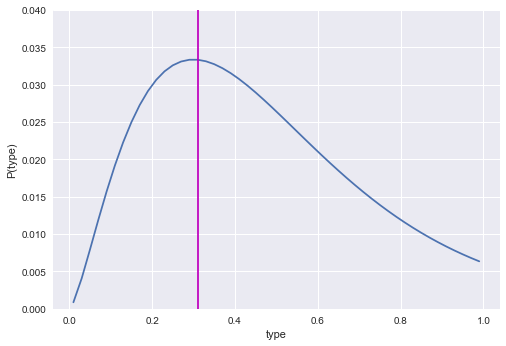

In [11]:
## Let's see what this distribution looks like
plt.plot(t_mdpt, p)
plt.plot(t_mdpt[15] * np.ones(len(np.linspace(0,0.4,30))), np.linspace(0,0.04,30), 'm', ms=4)
plt.xlabel('type')
plt.ylabel('P(type)')
plt.ylim(0,0.04)
plt.show()

Use inverse tranform sampling to sample from this distribution. First generate the cumulative distribution function and normalize:

In [12]:
P = np.zeros_like(t_bins)
P[1:] = np.cumsum(p)
P /= P[-1] 

Plot the cumulative distribution function. Note that the cdf was calculated over each bin, not each midpoint, since we want the sum up to the edge of each bin (assuming sum of first bin is zero.)

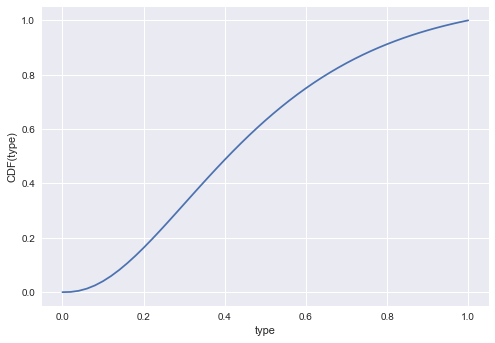

In [13]:
plt.plot(t_bins, P)
plt.xlabel('type')
plt.ylabel('CDF(type)')
plt.show()

Begin inverse sampling by first generating random numbers on the CDF y-axis from a uniform distribution. Next, we want to interpolate the inverse CDF - that is, we want to map t_bins over the randomly generated sample to get a smooth type distribution. 

In [14]:
u = rng.uniform(size=N)
t_interp = np.interp(u, P, t_bins)
## Map random number to cdf value, then map that cdf value back to 
## interpolated value on the x-axis
## Do this on a sample drawn from a uniform distribution

def sample(uniform_dist, x_interp, size):
    ## uniform_dist is proxy for cdf
    rndm = rng.uniform(size=size)
    idx = [(np.abs(uniform_dist - rndm[ii])).argmin() for ii in range(size)]
    return(x_interp[idx])

In [15]:
sampled_types = sample(u, t_interp, N)

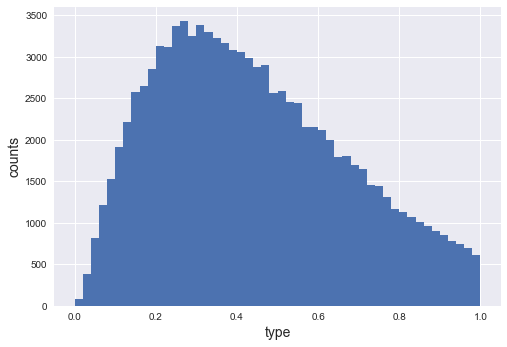

In [16]:
plt.hist(sampled_types, bins=t_bins)
#plt.plot(t_mdpt[15] * np.ones(len(np.linspace(0,3600,30))), np.linspace(0,3600,30), 'm', ms=4)
plt.xlabel('type', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.ylim(0,3600)
plt.show()

In [17]:
galaxies['t'] = sampled_types

### Sample redshifts

In [18]:
sampled_z = assign_redshifts(sampled_types)

In [19]:
galaxies['z'] = sampled_z

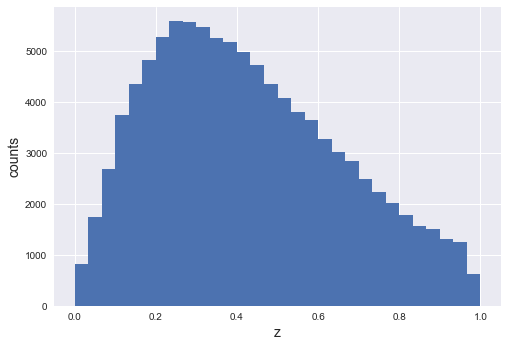

In [20]:
plt.hist(sampled_z, bins=30)
plt.xlabel('z', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.show()

### Sample features

In [27]:
sig_F = 0.02
features = feature_likelihood(sampled_types, scale=sig_F, rng=rng)

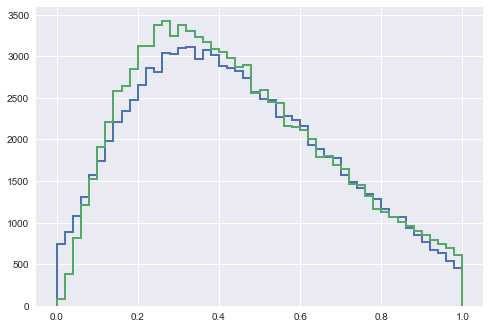

In [560]:
plt.hist(new_features, bins=t_bins, histtype='step', lw=2)
plt.hist(sampled_types, bins=t_bins, histtype='step', lw=2)
plt.show()

In [205]:
galaxies['F'] = features

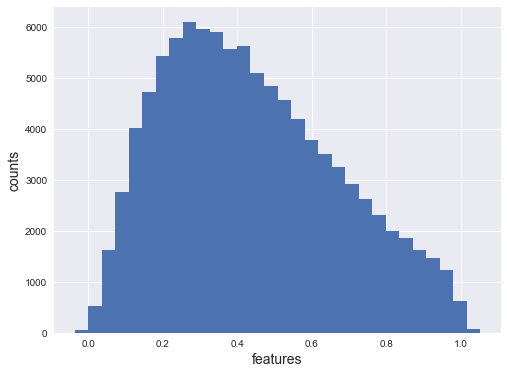

In [23]:
plt.figure(figsize=(8,6))
plt.hist(features, bins=30)
plt.xlabel('features', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.show()

### Sample positions

In [24]:
delta = delta_field(nx, nz, rms=2.5)

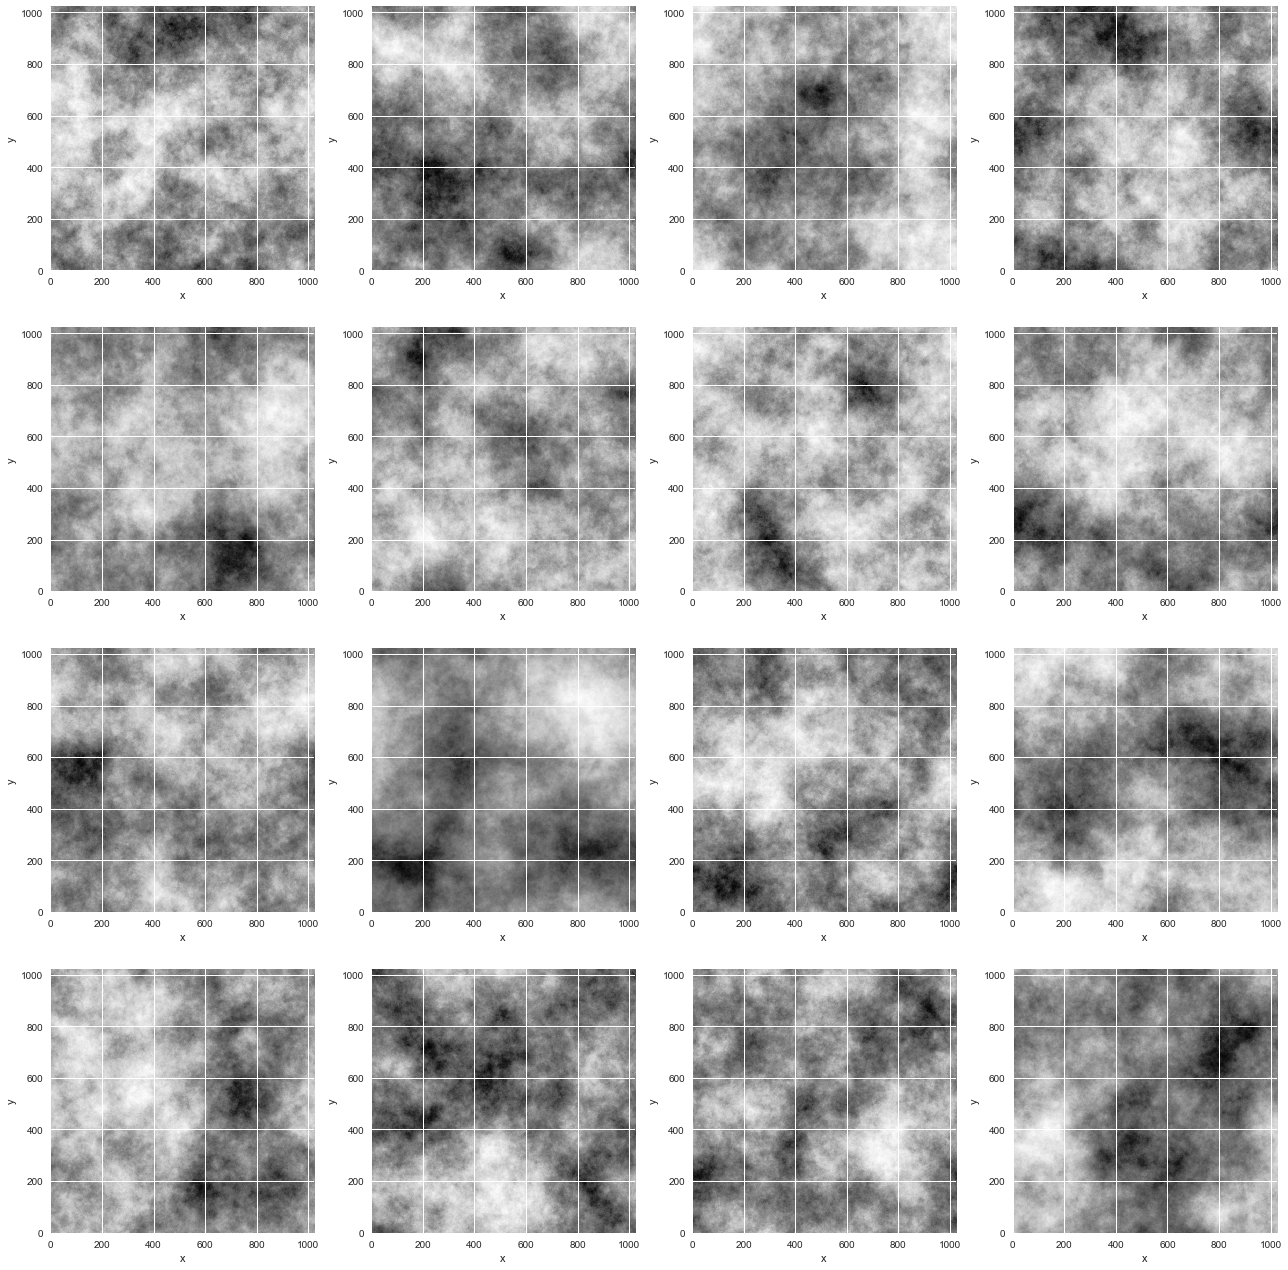

In [23]:
fig, axs = plt.subplots(4,4, figsize=(18,18))
axs = axs.ravel()

for i in range(16):
    axs[i].imshow(delta[:,:,i], interpolation='none', origin='lower')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
plt.tight_layout()    
plt.show()

In [24]:
## Clip to get non-negative density field
rho = np.maximum(0, delta + 1)

In [68]:
np.save('rho', rho)

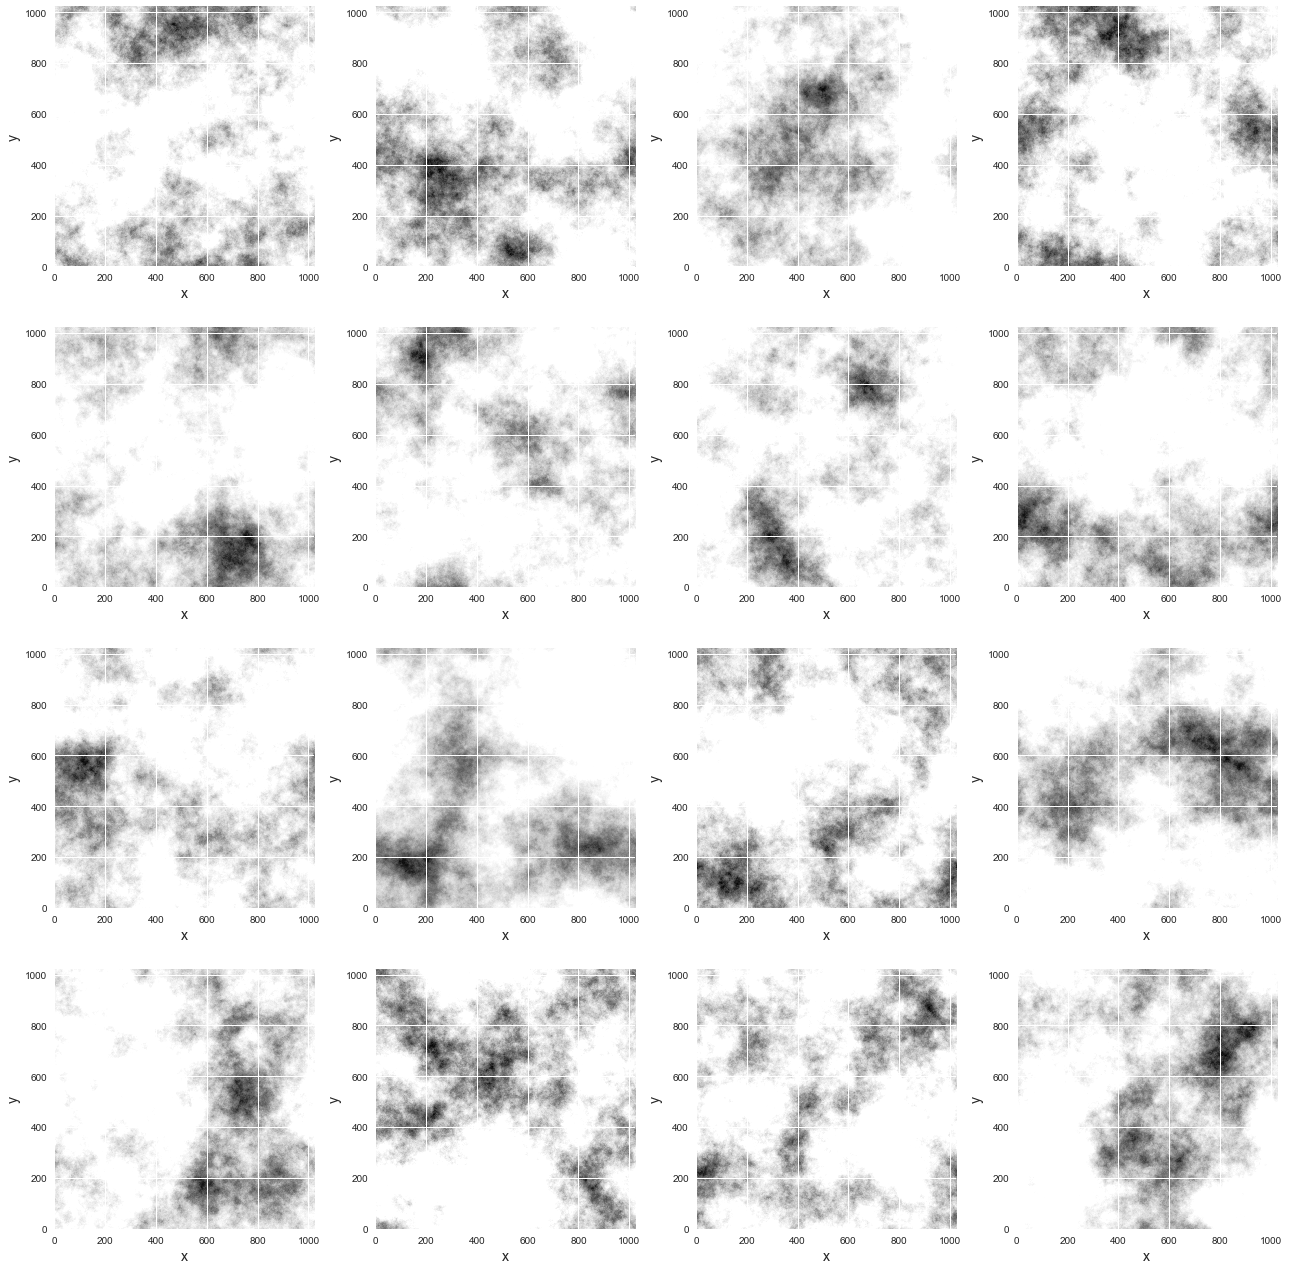

In [25]:
fig, axs = plt.subplots(4,4, figsize=(18,18))
axs = axs.ravel()

for i in range(16):
    axs[i].imshow(rho[:,:,i], interpolation='none', origin='lower')
    axs[i].set_xlabel('x', fontsize=14)
    axs[i].set_ylabel('y', fontsize=14)
plt.tight_layout() 
plt.show()

### Plot each redshift slice

In [17]:
z_bins = np.linspace(0, 1, nz+1)
z_mdpt = (z_bins[1:] + z_bins[:-1]) / 2
#z_indices = np.digitize(sampled_z, z_bins)

In [27]:
galaxies['z_bin'] = z_indices - 1

In [40]:
def find_2d_index(index, nx):
    index = np.asarray(index)
    ix = index % nx
    iy = index // nx
    return(ix, iy)

In [41]:
rho_flat = rho.reshape(nx*nx, 50)
cdf = np.cumsum(rho_flat, axis=0)
cdf /= cdf[-1,:]

unique, counts = np.unique(z_indices, return_counts=True)
n_subsamples = (counts * 0.05).astype(int)

for i in range(nz):
    u = rng.uniform(size=counts[i])
    ## this line takes the most time to run
    indices = [np.argmin(np.abs(cdf[:,i] - u[j])) for j in range(counts[i])]
    #ix, iy = np.unravel_index(indices, (nx,nx)) ## this doesn't sample in the correct locations...
    ix, iy = find_2d_index(indices, nx)
    positions = list(zip(ix,iy))
    galaxies_index = np.argwhere(galaxies['z_bin'] == i)
    galaxies['theta_x'][galaxies_index] = np.asarray(positions)[:,0].reshape(-1,1)
    galaxies['theta_y'][galaxies_index] = np.asarray(positions)[:,1].reshape(-1,1)

In [32]:
#galaxies.write('galaxies.fits', format='fits')

In [8]:
galaxies = Table.read('data/galaxies.fits')

In [42]:
np.sum(counts)

100000

Select a 5% subsample of galaxies in each slice and plot over random field:

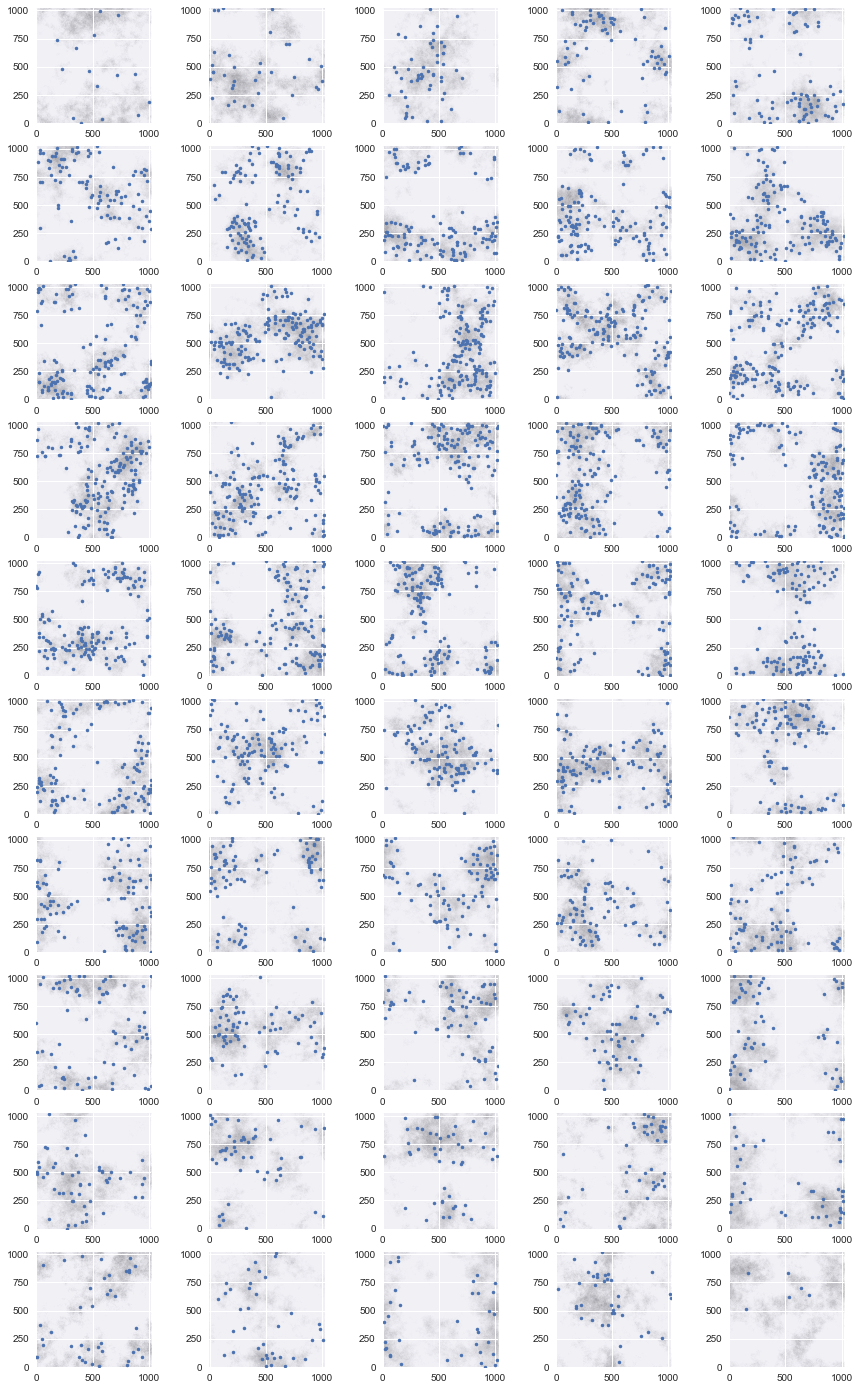

In [43]:
fig, axs = plt.subplots(10,5, figsize=(15,25))
axs = axs.ravel()

for i in range(nz):
    select = galaxies['z_bin'] == i
    axs[i].imshow(rho[:,:,i], origin='lower', alpha=0.3)
    axs[i].plot(galaxies[select]['theta_x'][:n_subsamples[i]], 
                galaxies[select]['theta_y'][:n_subsamples[i]], '.')

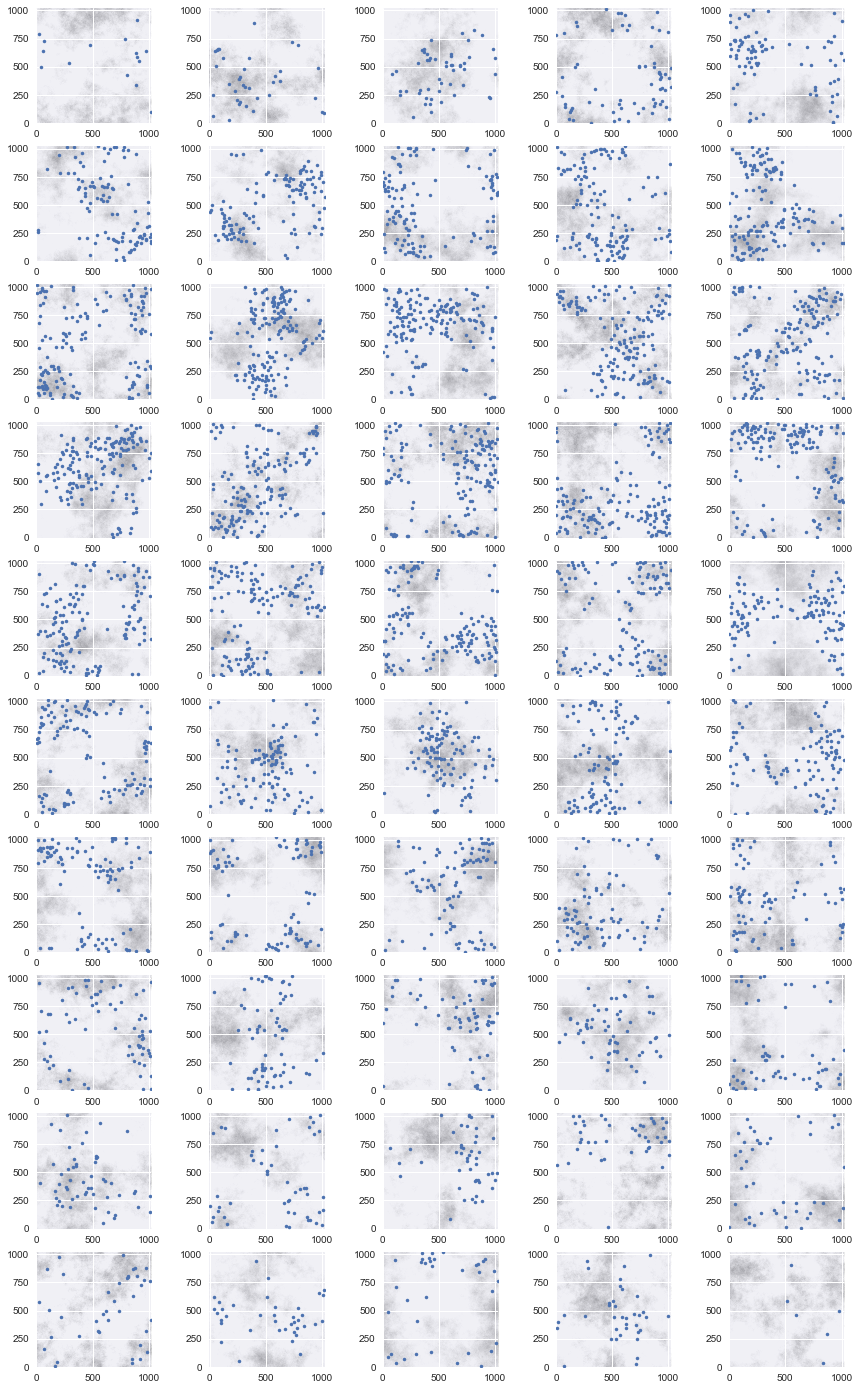

In [38]:
fig, axs = plt.subplots(10,5, figsize=(15,25))
axs = axs.ravel()

for i in range(nz):
    select = galaxies['z_bin'] == i
    axs[i].imshow(rho[:,:,i], origin='lower', alpha=0.3)
    axs[i].plot(galaxies[select]['theta_x'][:n_subsamples[i]], 
                galaxies[select]['theta_y'][:n_subsamples[i]], '.')

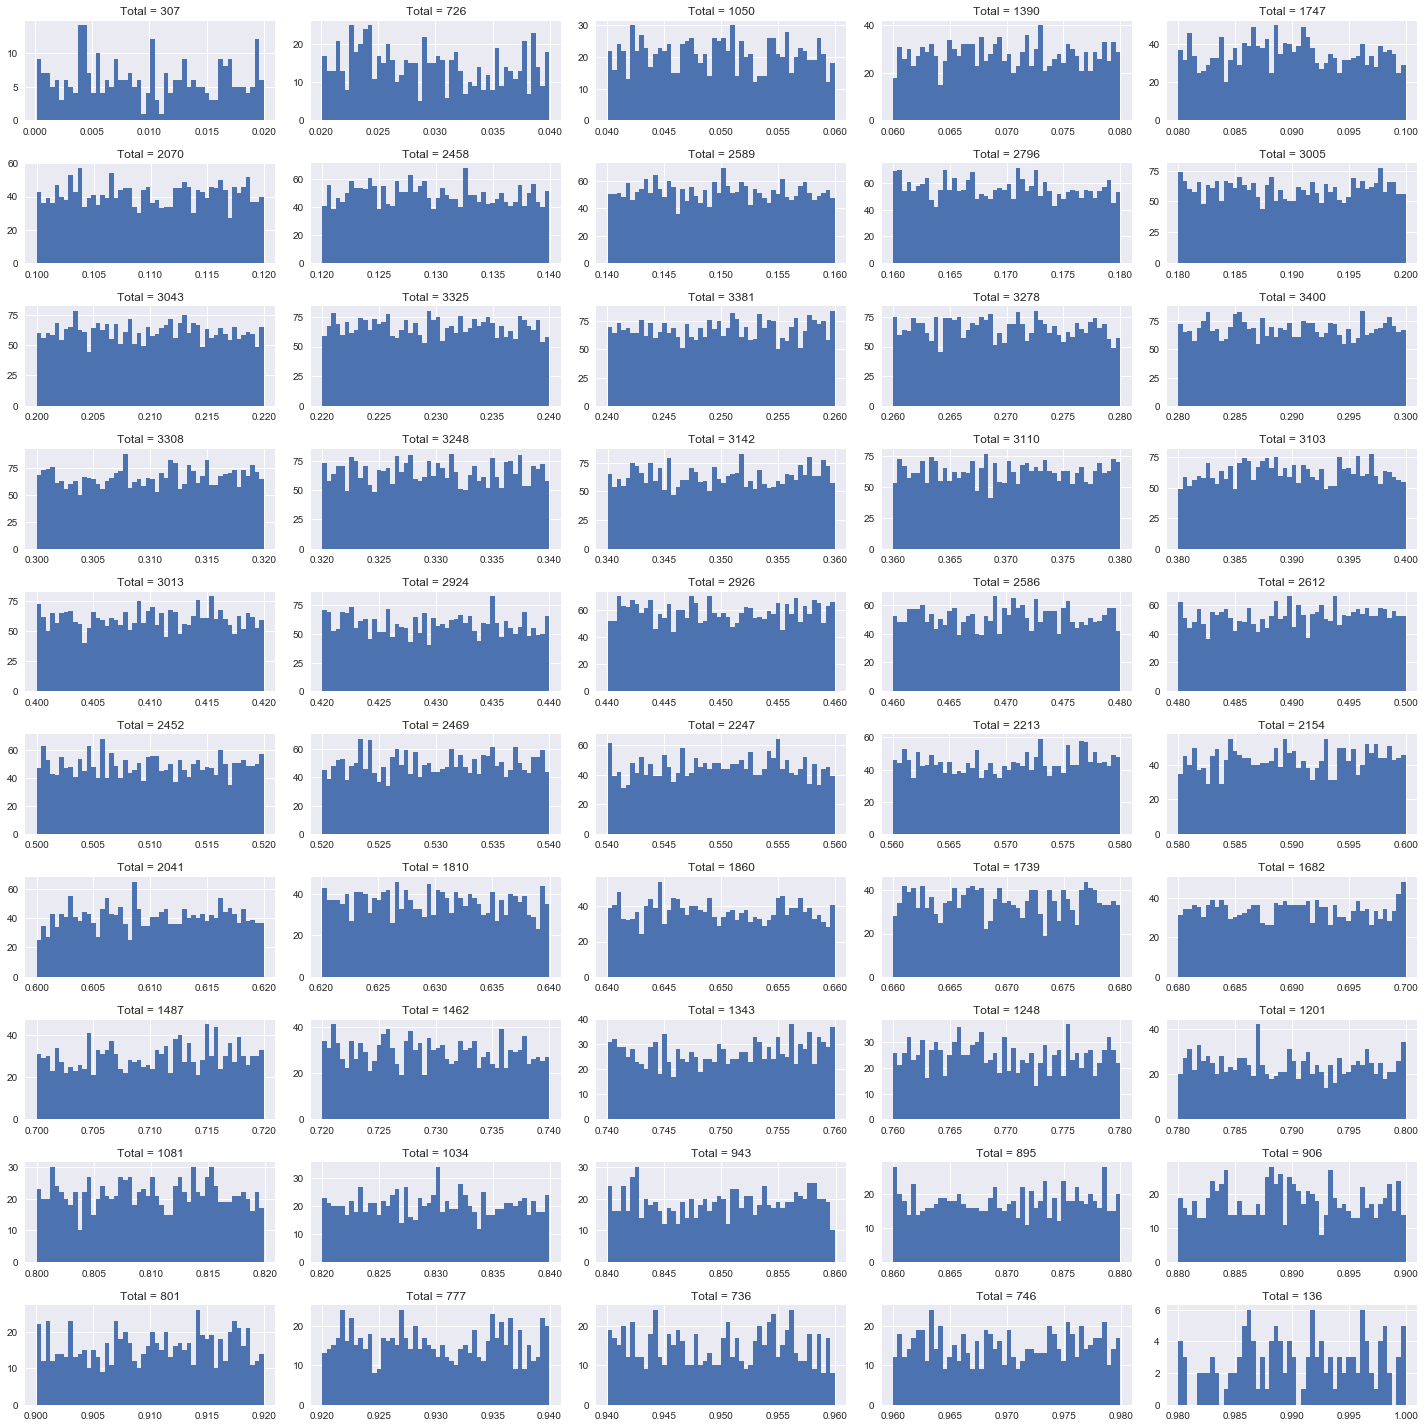

In [44]:
fig, axs = plt.subplots(10,5, figsize=(20,20))
axs = axs.ravel()

for j in range(nz):
    select = galaxies['z_bin'] == j
    axs[j].hist(galaxies[select]['z'], bins=nz)
    axs[j].set_title('Total = {}'.format(counts[j]))
plt.tight_layout()

#### Section IV Sampling & Priors

##### Step 1 of the Gibbs sampler
Create a 2d histogram of type and redshift:

In [33]:
h, edges = np.histogramdd([galaxies['z'], galaxies['t']], 
                          bins=(z_bins, t_bins))

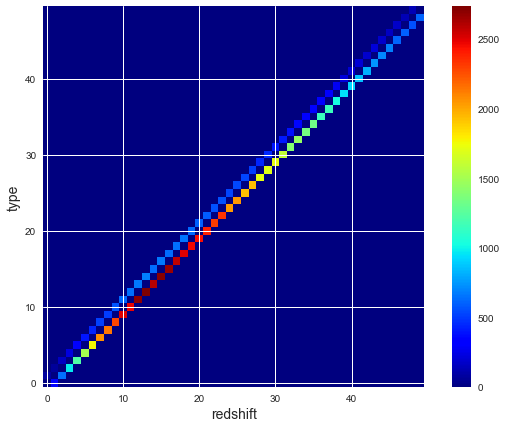

In [33]:
plt.figure(figsize=(10,7))
plt.imshow(h, cmap='jet', origin='lower', interpolation='none')
plt.xlabel('redshift', fontsize=14)
plt.ylabel('type', fontsize=14)
plt.colorbar()
plt.show()

First step in Gibbs sampler is to sample from the conditional posterior on $f$. This posterior is modeled as a Dirichlet distribution:
$$
p(f|z,t,F,\theta)\propto p(f) \prod_{z,t}f_{zt}^{N_{zt}}
$$
We know $\alpha_{i}-1$, which is $N_{zt} + 1$, and we know $x_{i}$, which is $f_{i}$, or the fraction of galaxies in each reshift-type bin with respect to the total number of galaxies. The Beta function is also easily calculated from the $N_{zt}$ for each bin:
$$
B(\vec{\alpha}) = \prod_{i=1}^{K} \frac{\Gamma(\alpha_{i})}{\Gamma(\Sigma_{i=1}^{K}\alpha_{i})} \;
$$

In [34]:
alpha = h.flatten() + 1
f = (h / np.sum(h)).flatten()

## Are conditions on the prior satisfied?
np.sum(f), np.min(f), np.max(f)

(1.0, 0.0, 0.02735)

Initialize conditional Dirichlet posterior on the fractions/probabilities for all z slices:

In [35]:
dirichlet = scipy.stats.dirichlet.rvs(alpha, random_state=rng, size=1)
dirichlet = dirichlet.reshape(nz,nt)

##### Step 2 of the Gibbs sampler

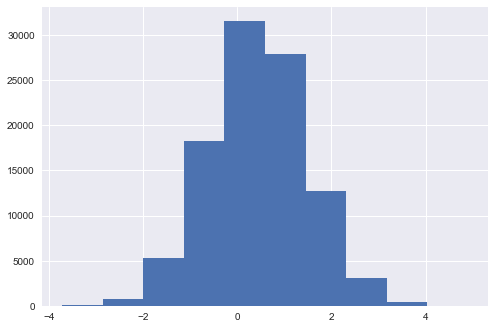

In [74]:
plt.hist(galaxies['F'])
plt.show()

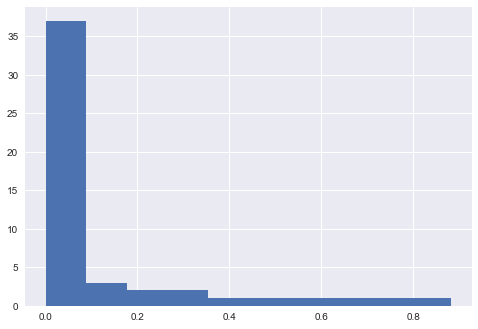

In [88]:
plt.hist(scipy.stats.norm.pdf(t_mdpt, loc=galaxies['F'][50000], scale=0.2))
plt.show()

In [108]:
probs = np.empty((nz,nt))
new_index = np.empty(N, dtype=int)

u = rng.uniform(size=N)

start = time.time()
for k in range(N): 
    norm = scipy.stats.norm.pdf(t_mdpt, loc=galaxies['F'][k], scale=sig_F) 
    probs = dirichlet * norm * rho[galaxies['theta_x'][k], galaxies['theta_y'][k]].reshape(-1,1)
    probs_cdf = np.cumsum(probs.flatten())
    probs_cdf /= probs_cdf[-1] 
    new_index[k] = np.abs(probs_cdf - u[k]).argmin()
print(time.time() - start)

new_iz, new_it = find_2d_index(new_index, nz)
new_z = z_mdpt[new_iz]
new_t = t_mdpt[new_it]

13.917973041534424


In [109]:
new_galaxies = Table(data=np.full((N,len(col_names)), 0), names=col_names)
new_galaxies['t'] = new_t
new_galaxies['z'] = new_z

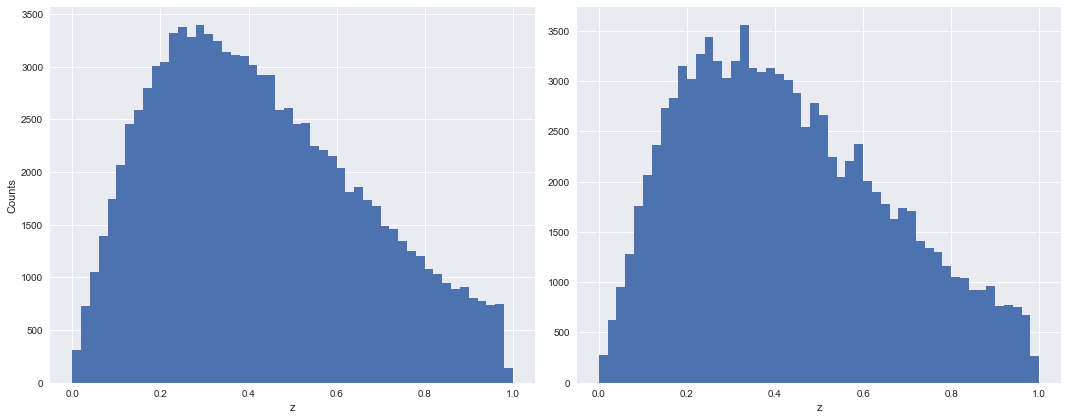

In [110]:
fig, axs = plt.subplots(1,2, figsize=(15,6))
axs = axs.ravel()

axs[0].hist(sampled_z, bins=z_bins)
axs[1].hist(new_galaxies['z'], bins=z_bins)
axs[0].set_xlabel('z')
axs[0].set_ylabel('Counts')
axs[1].set_xlabel('z')
plt.tight_layout()
plt.show()

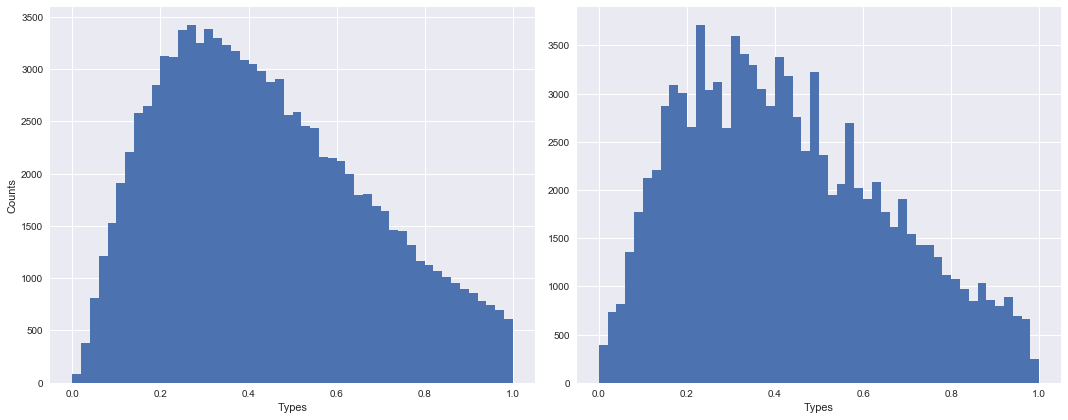

In [111]:
fig, axs = plt.subplots(1,2, figsize=(15,6))
axs = axs.ravel()

axs[0].hist(sampled_types, bins=t_bins)
axs[1].hist(new_galaxies['t'], bins=t_bins)
axs[0].set_xlabel('Types')
axs[0].set_ylabel('Counts')
axs[1].set_xlabel('Types')
plt.tight_layout()
plt.show()

In [ ]:
delta field is a realization of some assumed cosmology - doesnt change
simulate: F, theta - data
          z, t - latent
mcmc sampling:
    ztrue   ttrue
    z1 vec  t1 vec
    z2 vec  t2 vec
    
overplot all histograms generated from mcmc all sample cycles
the error in each is the standard deviation of the distribution of counts in each bin (ie: plot histogram of number of counts in each separate bin for redshift and type)

### Wrap everything into a single function

We start with a set of ($\vec{F}, \vec{\theta}, \vec{z}, \vec{t}$) values for all 100,000 galaxies. Next we want to run the MCMC sampler for a given number of cycles:

In [7]:
rho = np.load('rho.npy')

In [8]:
galaxies = Table.read('initial_data.fits', format='fits')

In [9]:
sig_F = 0.02

In [10]:
N=100000

In [41]:
def run_mcmc(initial_data, seed, sigma=sig_F, eps=1e-4, size=N, n_cycles=10):
    
    rng = np.random.RandomState(seed=seed)
    
    z_samples = np.empty((n_cycles, size), dtype=np.float64)
    t_samples = np.empty((n_cycles, size), dtype=np.float64)
    
    #z_samples = np.empty((n_cycles, size), dtype=float)
    #t_samples = np.empty((n_cycles, size), dtype=float)
    
    new_z = initial_data['z']
    new_t = initial_data['t']
    
    ## Added
    ##nt = 100
    ##t_bins = np.linspace(0, 1, nt+1)
    ##t_mdpt = (t_bins[1:] + t_bins[:-1]) / 2        
        
    for cycle in range(n_cycles):
        
        print('Cycle {} of {}'.format(cycle+1, n_cycles))
    
        ## Calculate probabilities
        h, _, _ = np.histogram2d(new_z, new_t, bins=(z_bins, t_bins))
                    
        h[h == 0] = eps
        alpha = h.flatten()

        ## Generate Dirichlet posterior for probabilities
        dirichlet = scipy.stats.dirichlet.rvs(alpha, random_state=rng, size=1)
        dirichlet = dirichlet.reshape(nz,nt)
        
        ## Sample from posterior
        new_indices = np.empty(size, dtype=int)

        for k in range(size): 
            norm = scipy.stats.norm.pdf(t_mdpt, loc=initial_data['F'][k], scale=sigma) 
            probs = dirichlet * norm #* rho[initial_data['theta_x'][k], initial_data['theta_y'][k]].reshape(-1,1)
            probs /= np.sum(probs)
            new_index = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=1, random_state=rng)
            #print(np.count_nonzero(new_index), new_index.shape)
            new_indices[k] = np.argmax(new_index)
                        
        unravel_index = np.unravel_index(new_indices, (nz,nt))
        #test_index = find_2d_index(new_indices, nz)
        #print(unravel_index, test_index) find_2d_index is flipped
        new_iz, new_it = unravel_index[0], unravel_index[1]
        #new_iz is the bin number
        #new_z = scipy.stats.uniform.rvs(loc=z_mdpt[new_iz], scale=np.full(len(new_iz), 0.01), random_state=rng)
        #new_t = scipy.stats.uniform.rvs(loc=t_mdpt[new_it], scale=np.full(len(new_it), 0.01), random_state=rng)
        new_z = scipy.stats.norm.rvs(loc=z_mdpt[new_iz], scale=np.full(len(new_iz), 0.01), random_state=rng)
        new_t = scipy.stats.norm.rvs(loc=t_mdpt[new_it], scale=np.full(len(new_it), 0.01), random_state=rng)
        #new_z = z_mdpt[new_iz]
        #new_t = t_mdpt[new_it]
        
        z_samples[cycle] = new_z
        t_samples[cycle] = new_t
    
    #return(h, dirichlet, new_index, probs, z_samples, t_samples)
    return(z_samples, t_samples)

In [42]:
## overplot all histograms and calculate sigma in each bin based on frequencies (np.percentile(2.5, 97.5)) 97.5 - 2.5
## but sample using uniform dist

In [43]:
start = time.time()
z_samples, t_samples = run_mcmc(galaxies, seed=11, n_cycles=1)
print(time.time() - start)

Cycle 1 of 1
20.795809030532837


In [33]:
z_samples_nc, t_samples_nc = run_mcmc(galaxies, seed=11, n_cycles=1)

Cycle 1 of 1


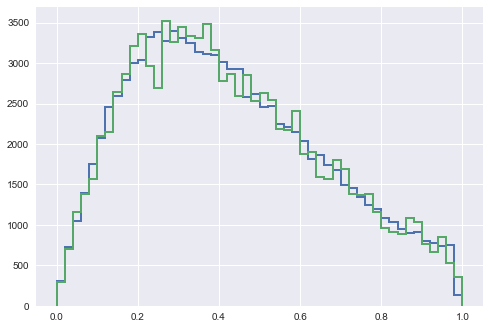

In [29]:
plt.hist(galaxies['z'], bins=z_bins, alpha=0.4)
plt.hist(z_samples[-1], bins=z_bins, histtype='step', lw=2)
plt.hist(z_samples_nc[-1], bins=z_bins, histtype='step', lw=2)
plt.show()

In [216]:
n_cycles = 1
start = time.time()
hist, d, n, p, sampled_z, sampled_t = run_mcmc(galaxies, seed=123, n_cycles=n_cycles)
print(time.time() - start)

Cycle 1 of 1
21.137441873550415


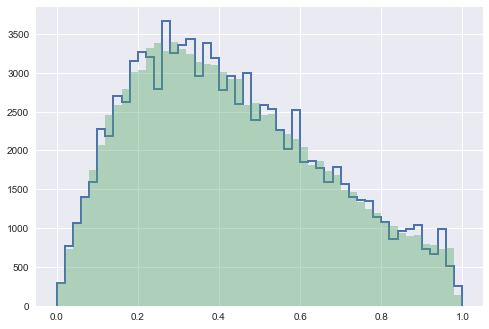

In [217]:
plt.hist(sampled_z.reshape(-1), histtype='step', bins=z_bins, lw=2)
plt.hist(galaxies['z'], alpha=0.4, bins=z_bins)
plt.show()

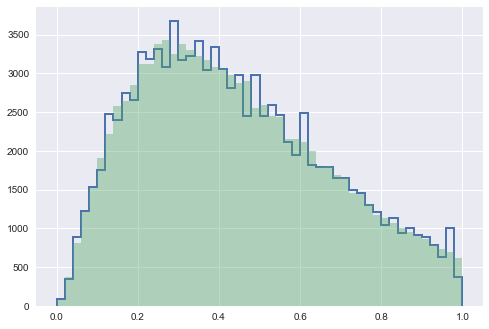

In [218]:
plt.hist(sampled_t.reshape(-1), histtype='step', bins=t_bins, lw=2)
plt.hist(galaxies['t'], alpha=0.4, bins=t_bins)
plt.show()

In [207]:
z_indices = np.digitize(sampled_z[-1], z_bins)
z_indices -= 1

In [153]:
z_indices

array([21, 18, 14, ..., 48, 22, 21])

In [157]:
sampled_z[1][z_indices == 14]

array([0.29763942, 0.29763942, 0.29763942, ..., 0.29763942, 0.29763942,
       0.29763942])

In [95]:
sampled_test = Table([sampled_z_d[-1].reshape(-1), sampled_t_d[-1].reshape(-1)], names=(['z', 't']))

In [96]:
sampled_test.write('sampled_test.fits', format='fits', overwrite=True)

In [88]:
Table.read('sampled_test.fits', format='fits')

<Table length=100000>
         z                   t         
      float64             float64      
------------------- -------------------
               0.75                0.77
               0.07                0.09
               0.33                0.35
               0.43 0.41000000000000003
0.29000000000000004                0.31
               0.77                0.79
               0.71                0.73
               0.45                0.47
               0.63                0.65
               0.27 0.29000000000000004
                ...                 ...
               0.27 0.29000000000000004
               0.55  0.5700000000000001
 0.5700000000000001                0.59
               0.31                0.33
0.29000000000000004                0.31
               0.25                0.27
0.15000000000000002 0.16999999999999998
0.15000000000000002 0.16999999999999998
0.29000000000000004                0.31
0.29000000000000004                0.31

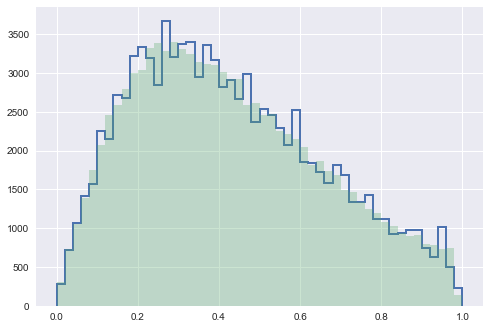

In [47]:
plt.hist(sampled_z_d[-1], bins=z_bins, histtype='step', lw=2)
plt.hist(galaxies['z'], bins=z_bins, alpha=0.3)
plt.show()

In [60]:
#galaxies.write('initial_data.fits', format='fits')

### Dirichlet prior only

In [58]:
n_cycles = 1
start = time.time()
hist_d, d_d, p_d, sampled_z_d, sampled_t_d = run_mcmc(galaxies, seed=123, n_cycles=n_cycles)
print(time.time() - start)

Cycle 1 of 1
26.999233961105347


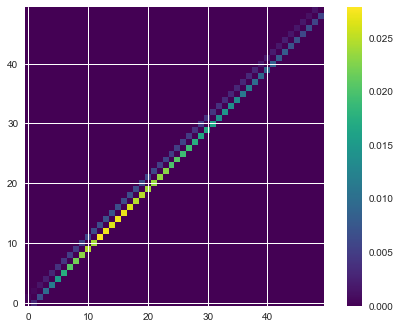

In [120]:
plt.imshow(hist_d, cmap='viridis', origin='lower')
plt.colorbar()
plt.show()

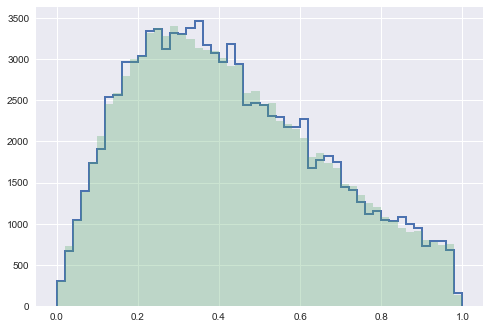

In [199]:
plt.hist(sampled_z_d[-1], bins=z_bins, histtype='step', lw=2)
plt.hist(galaxies['z'], bins=z_bins, alpha=0.3)
plt.show()

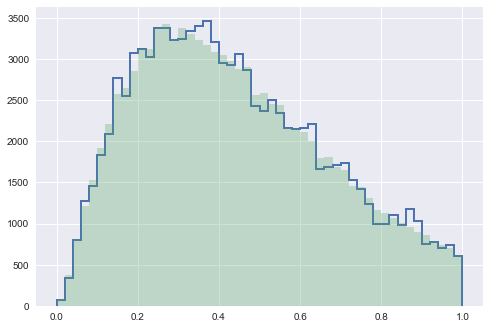

In [200]:
plt.hist(sampled_t_d[-1], bins=t_bins, histtype='step', lw=2)
plt.hist(galaxies['t'], bins=t_bins, alpha=0.3)
plt.show()

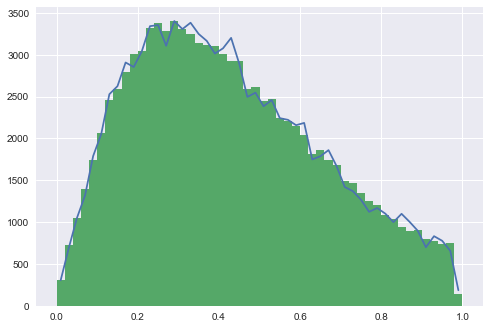

In [201]:
plt.plot(z_mdpt, np.sum(hist_d, axis=1))
plt.hist(galaxies['z'], bins=z_bins)
plt.show()

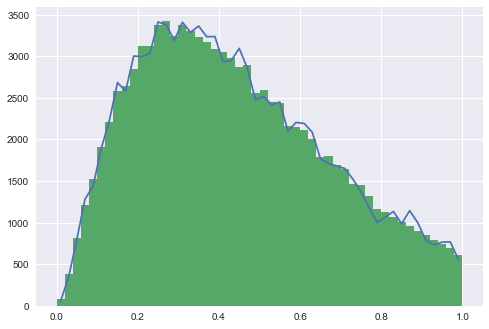

In [202]:
plt.plot(t_mdpt, np.sum(hist_d, axis=0))
plt.hist(galaxies['t'], bins=t_bins)
plt.show()

### With feature likelihood, but no clustering

In [119]:
n_cycles = 1
eps = 0.00001
start = time.time()
hist_f, d_f, n_f, p_f, sampled_z_f, sampled_t_f = run_mcmc(galaxies, seed=123, eps=eps, size=N, n_cycles=n_cycles)
print(time.time() - start)

Cycle 1 of 1
22.872309923171997


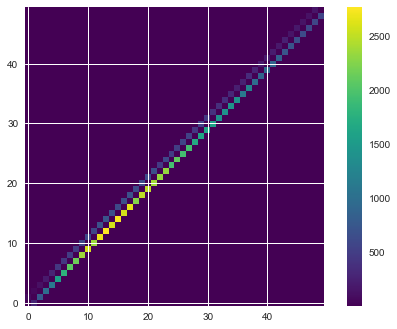

In [203]:
plt.imshow(hist_f, cmap='viridis', origin='lower')
plt.colorbar()
plt.show()

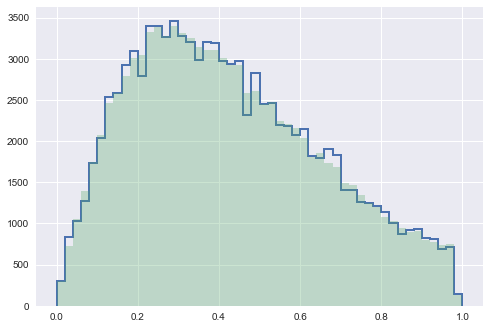

In [204]:
plt.hist(sampled_z_f[-1], bins=z_bins, histtype='step', lw=2)
plt.hist(galaxies['z'], bins=z_bins, alpha=0.3)
plt.show()

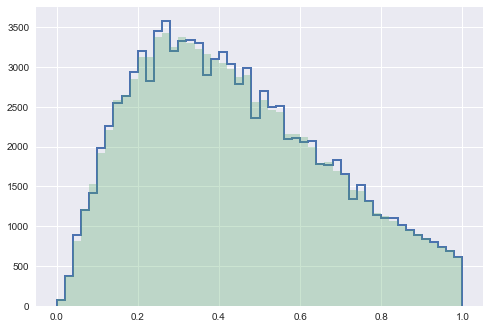

In [205]:
plt.hist(sampled_t_f[-1], bins=t_bins, histtype='step', lw=2)
plt.hist(galaxies['t'], bins=t_bins, alpha=0.3)
plt.show()

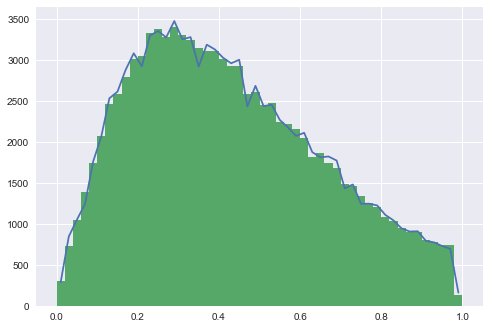

In [206]:
plt.plot(z_mdpt, np.sum(hist_f, axis=1))
plt.hist(galaxies['z'], bins=z_bins)
plt.show()

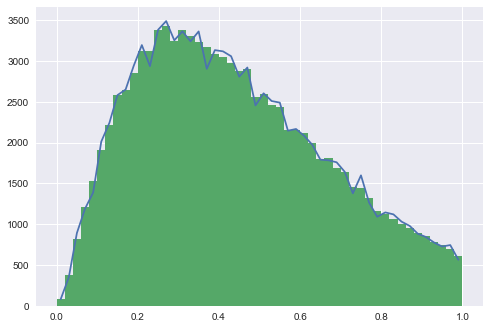

In [207]:
plt.plot(t_mdpt, np.sum(hist_f, axis=0))
plt.hist(galaxies['t'], bins=t_bins)
plt.show()

In [401]:
n_cycles = 5
start = time.time()
sampled_z, sampled_t = run_mcmc(galaxies, seed=123, n_cycles=n_cycles)
print(time.time() - start)

Cycle 1 of 5
Cycle 2 of 5
Cycle 3 of 5
Cycle 4 of 5
Cycle 5 of 5
111.05472612380981


### Sampling from the full posterior

In [369]:
n_cycles = 5
start = time.time()
sampled_z, sampled_t = run_mcmc(galaxies, seed=123, n_cycles=n_cycles)
print(time.time() - start)

Cycle 1 of 5
Cycle 2 of 5
Cycle 3 of 5
Cycle 4 of 5
Cycle 5 of 5
118.38700604438782


In [426]:
n_cycles = 20
start = time.time()
sampled_z, sampled_t = run_mcmc(galaxies, seed=123, n_cycles=n_cycles)
print(time.time() - start)

Cycle 1 of 20
Cycle 2 of 20
Cycle 3 of 20
Cycle 4 of 20
Cycle 5 of 20
Cycle 6 of 20
Cycle 7 of 20
Cycle 8 of 20
Cycle 9 of 20
Cycle 10 of 20
Cycle 11 of 20
Cycle 12 of 20
Cycle 13 of 20
Cycle 14 of 20
Cycle 15 of 20
Cycle 16 of 20
Cycle 17 of 20
Cycle 18 of 20
Cycle 19 of 20
Cycle 20 of 20
479.26390290260315


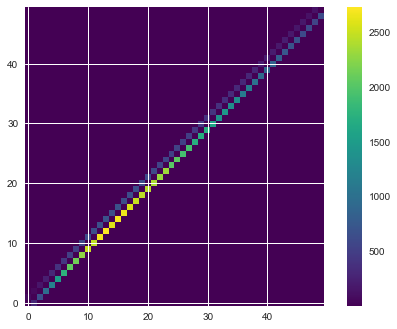

In [103]:
plt.imshow(hist, cmap='viridis', origin='lower')
plt.colorbar()
plt.show()

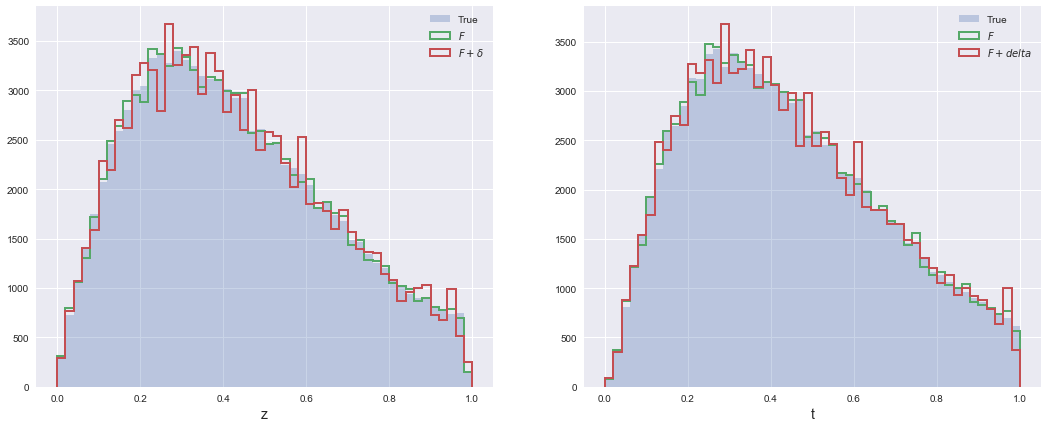

In [125]:
fig, axs = plt.subplots(1,2, figsize=(18,7))
axs = axs.ravel()

axs[0].hist(galaxies['z'], bins=z_bins, alpha=0.3, label='True')
axs[0].hist(sampled_z_f[-1], bins=z_bins, histtype='step', lw=2, label=r'$F$')
axs[0].hist(sampled_z[-1], bins=z_bins, histtype='step', lw=2, label=r'$F + \delta$')
axs[1].hist(galaxies['t'], bins=t_bins, alpha=0.3, label='True')
axs[1].hist(sampled_t_f[-1], bins=z_bins, histtype='step', lw=2, label=r'$F$')
axs[1].hist(sampled_t[-1], bins=t_bins, histtype='step', lw=2, label=r'$F + delta$')
axs[0].set_xlabel('z', fontsize=14)
axs[1].set_xlabel('t', fontsize=14)
axs[0].legend(loc=1)
axs[1].legend(loc=1)
plt.show()

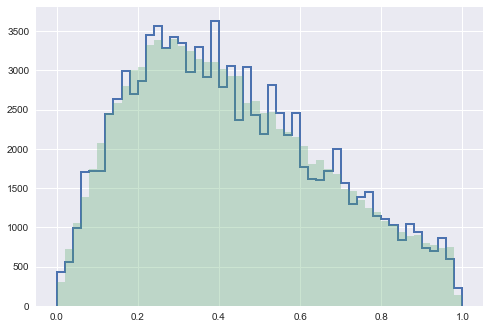

In [63]:
plt.hist(sampled_z[-1], bins=z_bins, histtype='step', lw=2)
plt.hist(galaxies['z'], bins=z_bins, alpha=0.3)
plt.show()

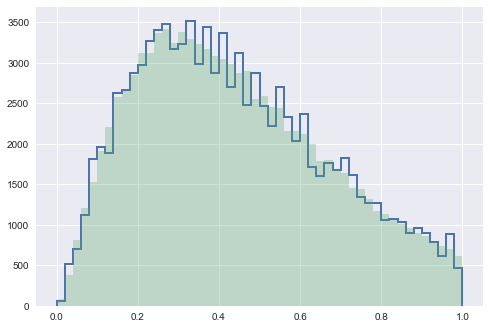

In [64]:
plt.hist(sampled_t[-1], bins=t_bins, histtype='step', lw=2)
plt.hist(galaxies['t'], bins=t_bins, alpha=0.3)
plt.show()

#### Figure 3

##### Redshift

In [216]:
h_vals, _ = np.histogram(sampled_z[-1], bins=z_bins)
hf_vals, _ = np.histogram(sampled_z_f[-1], bins=z_bins)

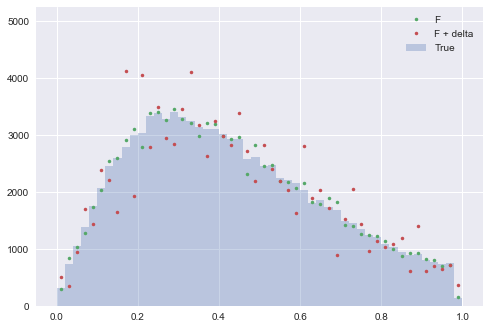

In [217]:
plt.hist(galaxies['z'], histtype='stepfilled', bins=z_bins, alpha=0.3, label='True')
plt.plot(z_mdpt, hf_vals, '.', label='F')
plt.plot(z_mdpt, h_vals, '.', label='F + delta')
plt.legend()
plt.ylim(0,5250)
plt.show()

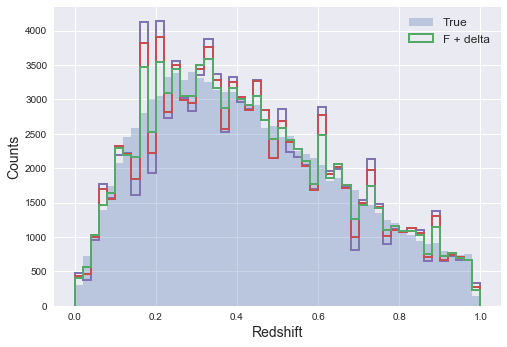

In [164]:
## it gets worse the more cycles we do...
plt.hist(galaxies['z'], histtype='stepfilled', bins=z_bins, alpha=0.3, label='True')
plt.hist([sampled_z[i] for i in range(n_cycles)], histtype='step', bins=z_bins, label='F + delta', lw=2)
plt.xlabel('Redshift', fontsize='14')
plt.ylabel('Counts', fontsize='14')
plt.legend(fontsize='12')
plt.show()

##### Type

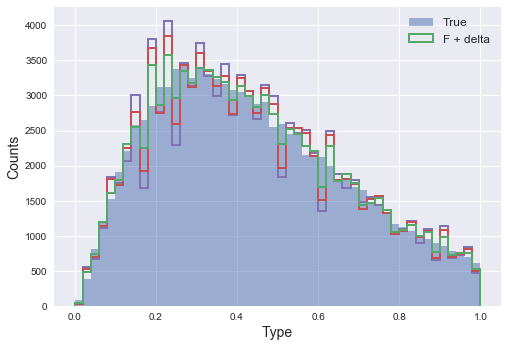

In [165]:
plt.hist(galaxies['t'], histtype='stepfilled', bins=t_bins, alpha=0.5, label='True')
plt.hist([sampled_t[i] for i in range(n_cycles)], histtype='step', bins=t_bins, label='F + delta', lw=2)
plt.xlabel('Type', fontsize='14')
plt.ylabel('Counts', fontsize='14')
plt.legend(fontsize='12')
plt.show()

Calculate error for each bin in type and redshift:

In [182]:
z_counts_per_bin = [np.histogram(sampled_z[i], z_bins)[0] for i in range(n_cycles)]
z_counts_per_bin = np.asarray(z_counts_per_bin)

In [183]:
z_errors = np.std(z_counts_per_bin, axis=0)
z_med = np.median(z_counts_per_bin, axis=0) # taking avg is same as: np.histogram(sampled_z, z_bins)[0] / n_cycles

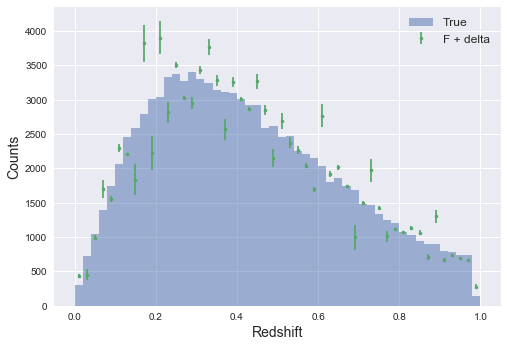

In [184]:
plt.hist(galaxies['z'], histtype='stepfilled', bins=z_bins, alpha=0.5, label='True')
plt.errorbar(z_mdpt, z_med, yerr=z_errors, fmt='.', label='F + delta')
plt.xlabel('Redshift', fontsize='14')
plt.ylabel('Counts', fontsize='14')
plt.legend(fontsize='12')
plt.show()

In [186]:
t_counts_per_bin = [np.histogram(sampled_t[i], z_bins)[0] for i in range(n_cycles)]
t_counts_per_bin = np.asarray(t_counts_per_bin)

In [187]:
t_errors = np.std(t_counts_per_bin, axis=0)
t_med = np.median(t_counts_per_bin, axis=0) # taking avg is same as: np.histogram(test_t, t_bins)[0] / n_cycles

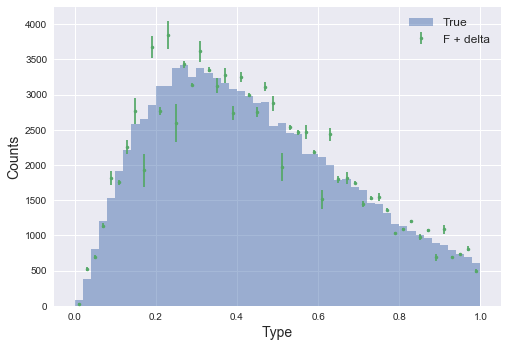

In [188]:
plt.hist(galaxies['t'], histtype='stepfilled', bins=z_bins, alpha=0.5, label='True')
plt.errorbar(t_mdpt, t_med, yerr=t_errors, fmt='.', label='F + delta')
plt.xlabel('Type', fontsize='14')
plt.ylabel('Counts', fontsize='14')
plt.legend(fontsize='12')
plt.show()

### test dirichlet

In [346]:
## Both these distributions have a mean of 0.5
x = rng.normal(loc=0.5, scale=0.1, size=50000)
#x = rng.exponential(scale=0.1, size=1000)
y = rng.uniform(size=50000)

In [283]:
x_bins = np.linspace(0,1,51)
y_bins = np.linspace(0,1,21)

x_mdpt = 0.5 * (x_bins[1:] + x_bins[:-1])
y_mdpt = 0.5 * (y_bins[1:] + y_bins[:-1])

In [284]:
h, _, _ = np.histogram2d(y, x, bins=(y_bins, x_bins))

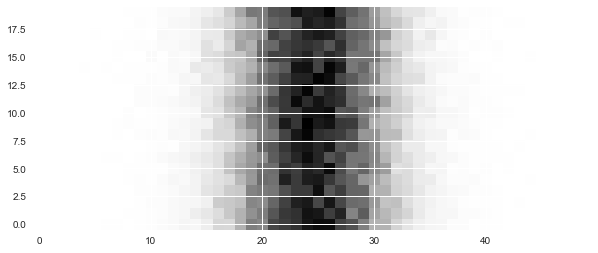

In [172]:
plt.figure(figsize=(10,7))
plt.imshow(h, origin='low')
plt.show()

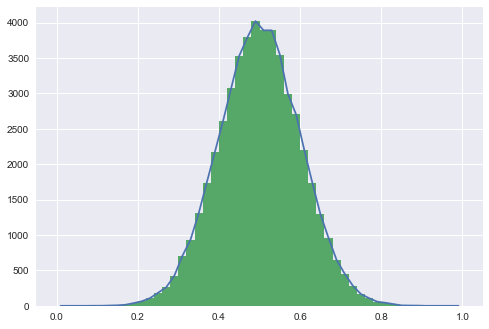

In [173]:
## Plot projection of x at the midpoint of each x bin
plt.plot(x_mdpt, np.sum(h, axis=0))
plt.hist(x, bins=x_bins)
plt.show()

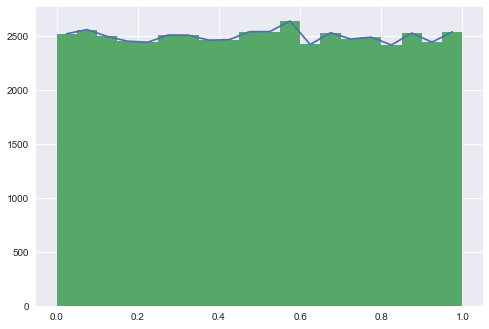

In [174]:
## Plot projection of y at the midpoint of each y bin
plt.plot(y_mdpt, np.sum(h, axis=1))
plt.hist(y, bins=y_bins)
plt.show()

In [175]:
## Verify that 2d histogram yields same counts as 1d histograms
y_hist, _ = np.histogram(y, bins=y_bins)
x_hist, _ = np.histogram(x, bins=x_bins)

In [176]:
print(np.all(np.sum(h, axis=0) == x_hist))
print(np.all(np.sum(h, axis=1) == y_hist))

True
True


In [177]:
## Same holds for histdd?
histdd, _ = np.histogramdd([y,x], bins=(y_bins, x_bins))

In [178]:
np.all(histdd == h)

True

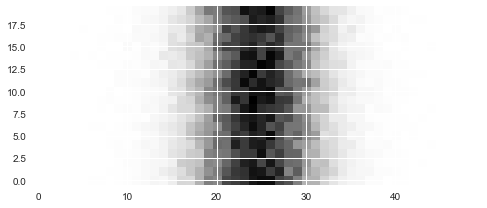

In [179]:
plt.imshow(histdd, origin='lower')
plt.show()

Ok, so histogram is fine...maybe has something to do with generating the Dirichlet distribution..

In [440]:
h, _, _ = np.histogram2d(y, x, bins=(y_bins, x_bins))

In [441]:
h[h == 0] = 0.5

In [442]:
alpha = h.flatten()
d = scipy.stats.dirichlet.rvs(alpha, random_state=rng, size=1)

In [443]:
d = d.reshape(20,50) # new probabilities f_yx (f_zt)
np.sum(d)

1.0000000000000004

In [444]:
fractions = h / np.sum(h.flatten())
np.sum(fractions)

1.0

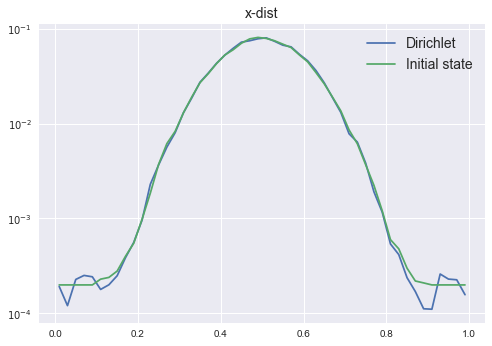

In [445]:
plt.plot(x_mdpt, np.sum(d, axis=0), label='Dirichlet')
plt.plot(x_mdpt, np.sum(fractions, axis=0), label='Initial state')
plt.yscale('log')
plt.title('x-dist', fontsize=14)
plt.legend(loc=1, fontsize=14)
plt.show()

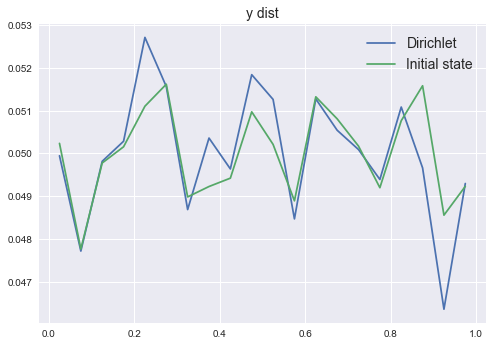

In [331]:
plt.plot(y_mdpt, np.sum(d, axis=1), label='Dirichlet')
plt.plot(y_mdpt, np.sum(fractions, axis=1), label='Initial state')
plt.title('y dist', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()

#### f_zt generated from Dirichlet distribution

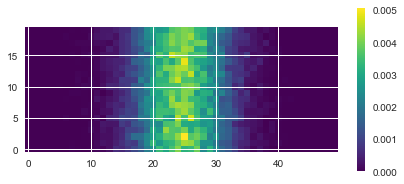

In [138]:
# New probabilities
plt.figure(figsize=(7,3))
plt.imshow(d, origin='low', cmap='viridis')
plt.colorbar()
plt.show()

#### Compare do distribution of number counts from initial simulation

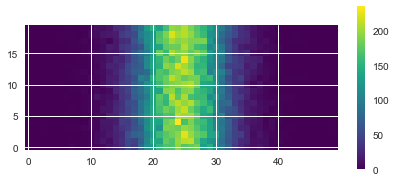

In [139]:
# Number counts from last iteration
plt.figure(figsize=(7,3))
plt.imshow(h, origin='low', cmap='viridis')
plt.colorbar()
plt.show()

In [165]:
fractions = h / np.sum(h.flatten())
np.sum(fractions)

0.9999999999999999

### Original f_zt 

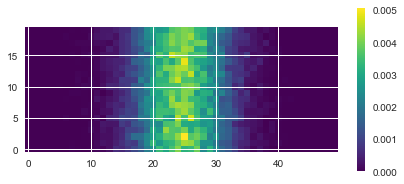

In [141]:
plt.figure(figsize=(7,3))
plt.imshow(d, origin='low', cmap='viridis')
plt.colorbar()
plt.show()

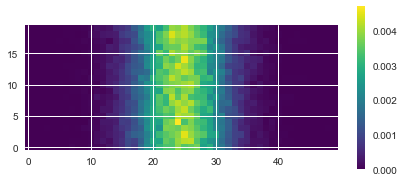

In [142]:
# Probabilities from last iteration
plt.figure(figsize=(7,3))
plt.imshow(fractions, origin='low', cmap='viridis')
plt.colorbar()
plt.show()

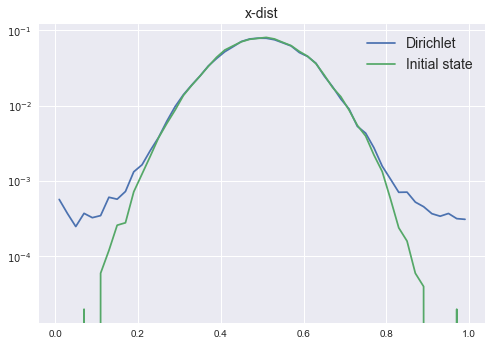

In [148]:
plt.plot(x_mdpt, np.sum(d, axis=0), label='Dirichlet')
plt.plot(x_mdpt, np.sum(fractions, axis=0), label='Initial state')
plt.yscale('log')
plt.title('x-dist', fontsize=14)
plt.legend(loc=1, fontsize=14)
plt.show()

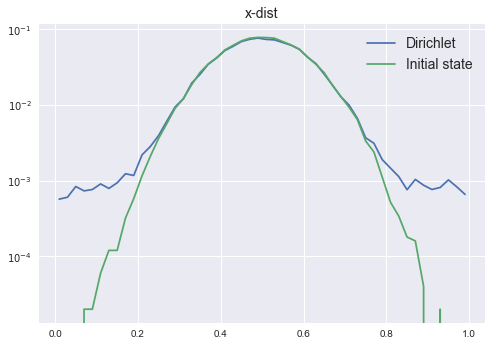

In [798]:
plt.plot(x_mdpt, np.sum(d, axis=0), label='Dirichlet')
plt.plot(x_mdpt, np.sum(fractions, axis=0), label='Initial state')
plt.yscale('log')
plt.title('x-dist', fontsize=14)
plt.legend(loc=1, fontsize=14)
plt.show()

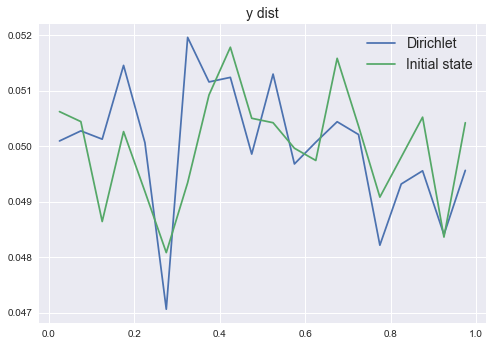

In [813]:
plt.plot(y_mdpt, np.sum(d, axis=1), label='Dirichlet')
plt.plot(y_mdpt, np.sum(fractions, axis=1), label='Initial state')
plt.title('y dist', fontsize=14)
plt.legend(loc=1, fontsize=14)
plt.show()

### Do my own sampling from Dirichlet distribution to try and understand the $\alpha - 1$ in the exponent...

http://en.wikipedia.org/wiki/Dirichlet_distribution#Random_number_generation

This consists of two steps:
    1) sample N random samples from the Gamma distribution $\Gamma(\alpha_{i}, 1)$
    2) set each random variable to: $x_{i} = \frac{y_{i}}{\Sigma_{j=1}^{N}y_{j}}$

Inverse transform sample from the CDF of the Gamma ditribution: $\frac{\gamma(\alpha, \beta x)}{\Gamma(\alpha)}$

In [211]:
a = h.flatten() + 1 # this is the N in the exponent

In [146]:
m = np.linspace(0,1,1001)
m_mdpt = 0.5 * (m[1:] + m[:-1])
ginc = scipy.special.gammainc(a[0], m_mdpt)
cdf = ginc / scipy.special.gamma(a[0])
cdf /= cdf[-1]

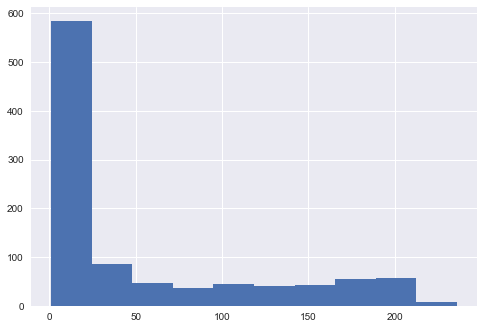

In [147]:
plt.hist(a)
plt.show()

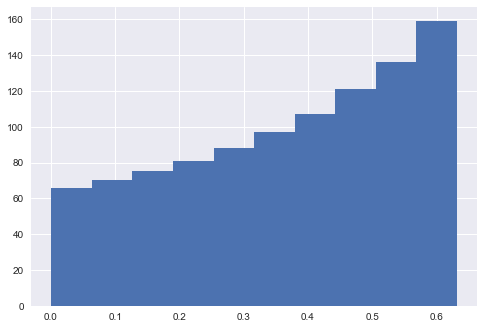

In [148]:
plt.hist(ginc)
plt.show()

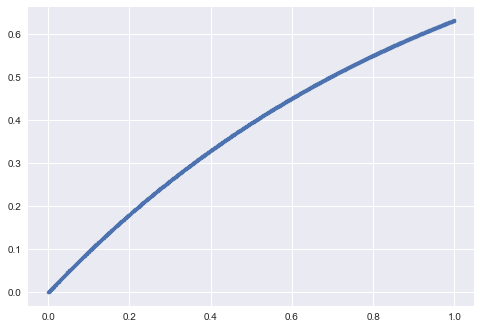

In [149]:
plt.plot(m_mdpt, ginc, '.')
plt.show()

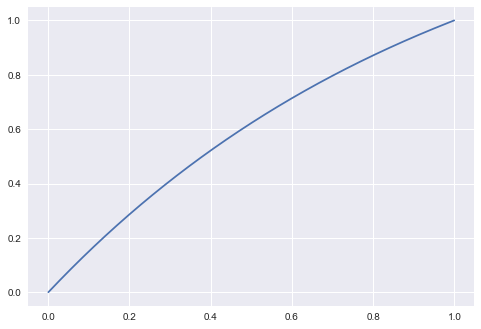

In [151]:
plt.plot(m_mdpt, cdf)
plt.show()

In [152]:
rndm = rng.uniform(size=1)
rndmn = rng.uniform(size=1000)

In [153]:
idx = np.abs(rndm - cdf).argmin()

In [154]:
idxn = [np.abs(rndmn[i] - cdf).argmin() for i in range(1000)]

In [155]:
pdf = (m_mdpt**(a[0]-1) * np.exp(-m_mdpt)) / scipy.special.gamma(a[0])

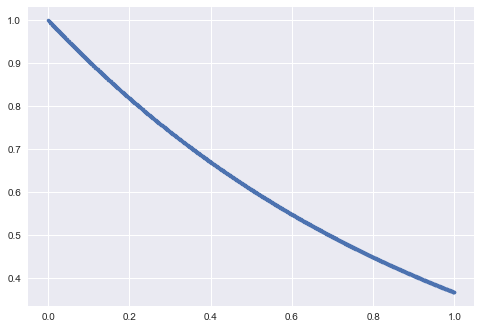

In [156]:
plt.plot(m_mdpt, pdf, '.')
plt.show()

In [157]:
y = pdf[idx]

In [160]:
x = y / np.sum(pdf[idxn])

In [243]:
eps = 0.000001
a = h.flatten() + eps # this is the N in the exponent
params = a
sample = [rng.gamma(alpha,1) for alpha in params]
sample = [v/sum(sample) for v in sample]

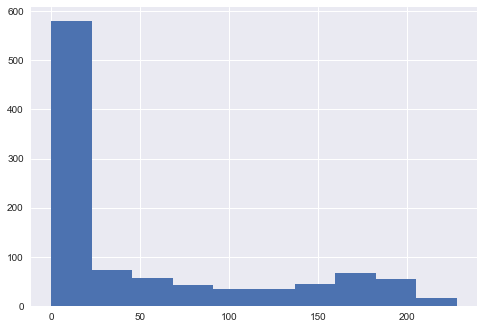

In [244]:
plt.hist(a)
plt.show()

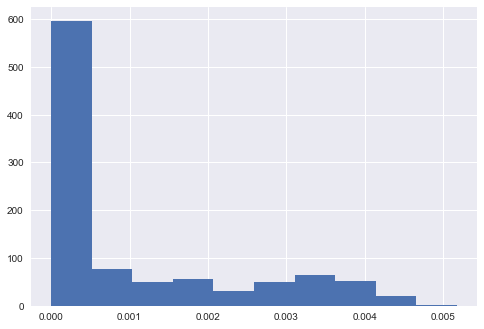

In [245]:
plt.hist(sample)
plt.show()

In [246]:
fractions = h / np.sum(h.flatten())
np.sum(fractions)

0.9999999999999999

In [247]:
sample = np.asarray(sample).reshape(20,50)

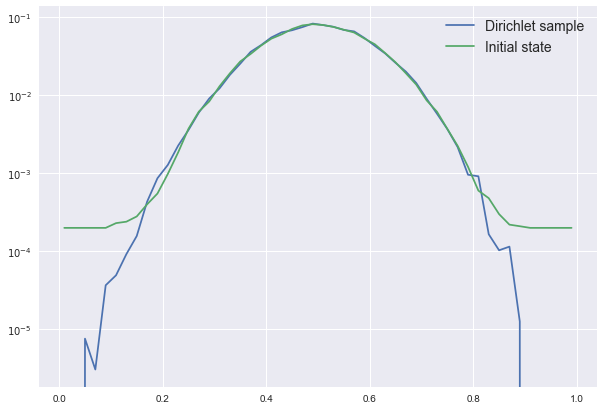

In [480]:
plt.figure(figsize=(10,7))
plt.plot(x_mdpt, np.sum(sample, axis=0), label='Dirichlet sample')
plt.plot(x_mdpt, np.sum(fractions, axis=0), label='Initial state')
plt.yscale('log')
plt.legend(fontsize=14, loc=1)
plt.show()

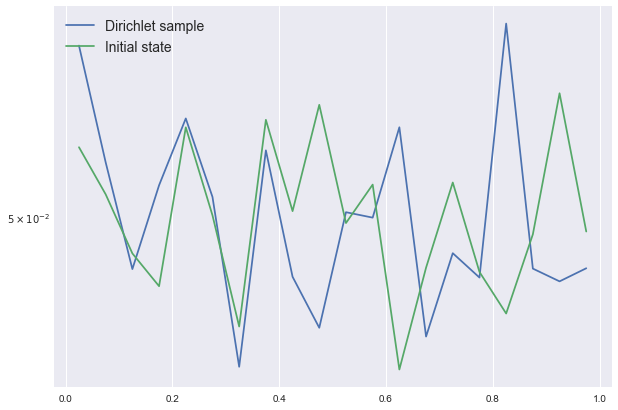

In [479]:
plt.figure(figsize=(10,7))
plt.plot(y_mdpt, np.sum(sample, axis=1), label='Dirichlet sample')
plt.plot(y_mdpt, np.sum(fractions, axis=1), label='Initial state')
plt.yscale('log')
#plt.ylim(0,None)
plt.legend(fontsize=14, loc=2)
plt.show()

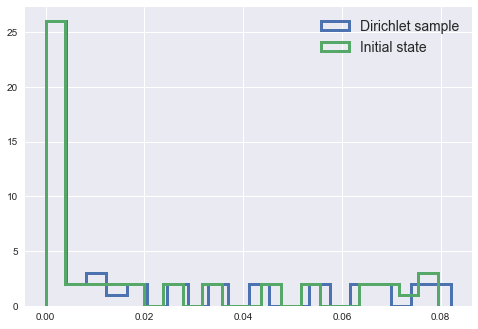

In [276]:
plt.hist(np.sum(sample, axis=0), bins=20, histtype='step', lw=3, label='Dirichlet sample')
plt.hist(np.sum(fractions, axis=0), bins=20, histtype='step', lw=3, label='Initial state')
#plt.yscale('log')
plt.legend(fontsize=14, loc=1)
plt.show()

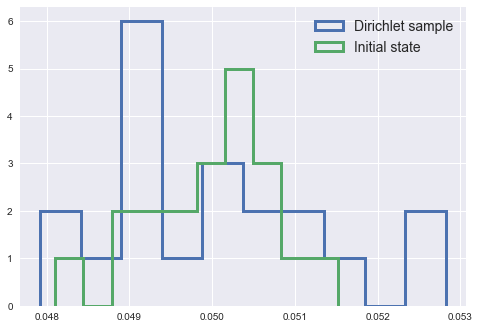

In [279]:
plt.hist(np.sum(sample, axis=1), bins=10, histtype='step', lw=3, label='Dirichlet sample')
plt.hist(np.sum(fractions, axis=1), bins=10, histtype='step', lw=3, label='Initial state')
#plt.yscale('log')
plt.legend(fontsize=14, loc=1)
plt.show()

In [391]:
fs = 10  # fontsize
pos = [1, 2, 4, 5, 7, 8]
data = [np.random.normal(0, std, size=100) for std in pos]

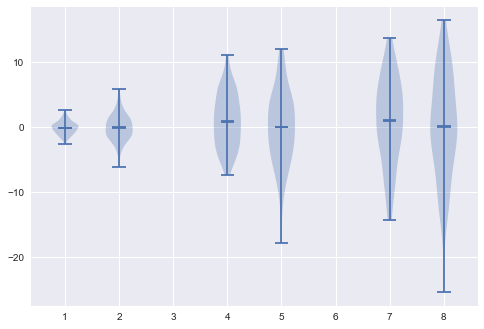

In [392]:
plt.violinplot(data, pos, points=40, widths=0.5,
                      showmeans=True, showextrema=True, showmedians=True,
                      bw_method='silverman')
plt.show()

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


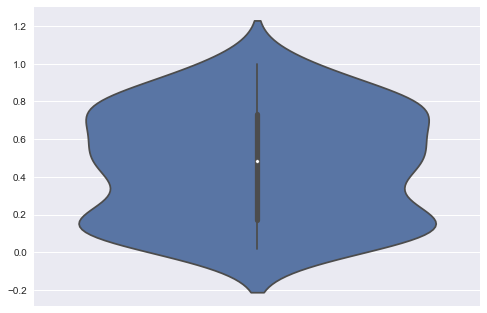

In [378]:
foo = np.random.rand(100)
sns.violinplot(foo, orient='v')
plt.show()

In [337]:
t = np.empty((20,50), dtype=int)
for j in range(n_cycles):
    t[j], _ = np.histogram(sampled_z[0], bins=z_bins)

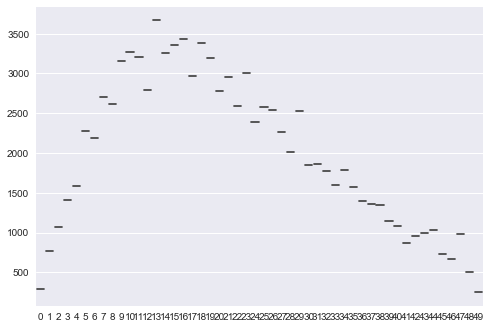

In [340]:
sns.violinplot(data=t, gridsize=2)

In [396]:
z = np.empty((n_cycles,nz), dtype=int)
for j in range(n_cycles):
    z[j], _ = np.histogram(sampled_z[j], bins=z_bins)

In [461]:
t = np.empty((n_cycles,nt), dtype=int)
for j in range(n_cycles):
    t[j], _ = np.histogram(sampled_t[j], bins=t_bins)

In [402]:
z_nc = np.empty((n_cycles,nz), dtype=int)
for j in range(n_cycles):
    z_nc[j], _ = np.histogram(sampled_z[j], bins=z_bins)

In [420]:
t_nc = np.empty((n_cycles,nt), dtype=int)
for j in range(n_cycles):
    t_nc[j], _ = np.histogram(sampled_t[j], bins=t_bins)

In [112]:
import matplotlib.patches as patches

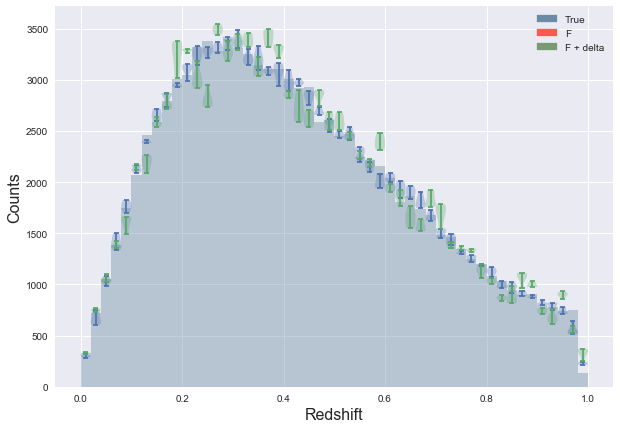

In [459]:
blue = sns.xkcd_rgb["grey blue"]
red = sns.xkcd_rgb["coral"]
green = sns.xkcd_rgb["grey green"]

blue_patch = patches.Patch(color=blue)
red_patch = patches.Patch(color=red)
green_patch = patches.Patch(color=green)

plt.figure(figsize=(10,7))
ax = plt.subplot(111)
plt.hist(galaxies['z'], bins=z_bins, alpha=0.4, label='True', color=blue)
plt.violinplot(z_nc, z_mdpt, widths=0.02, points=40)
plt.violinplot(z, z_mdpt, widths=0.02, points=40)
plt.xlabel('Redshift', fontsize=16)
plt.ylabel('Counts', fontsize=16)
ax.legend([blue_patch, red_patch, green_patch], ['True', 'F', 'F + delta'])
plt.show()

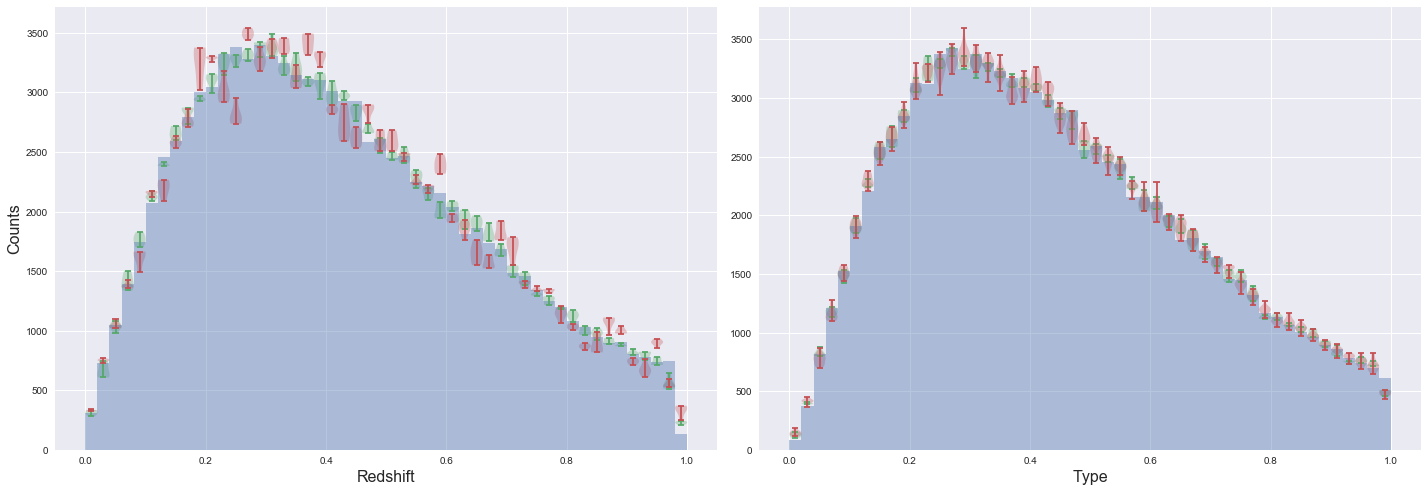

In [468]:
fig, axs = plt.subplots(1,2, figsize=(20,7))
axs = axs.ravel()

axs[0].hist(galaxies['z'], bins=z_bins, alpha=0.4, label='True')
axs[0].violinplot(z_nc, z_mdpt, widths=0.02, points=40)
axs[0].violinplot(z, z_mdpt, widths=0.02, points=40)
axs[0].set_xlabel('Redshift', fontsize=16)
axs[0].set_ylabel('Counts', fontsize=16)

axs[1].hist(galaxies['t'], bins=t_bins, alpha=0.4, label='True')
axs[1].violinplot(t_nc, t_mdpt, widths=0.02, points=40)
axs[1].violinplot(t, t_mdpt, widths=0.02, points=40)
axs[1].set_xlabel('Type', fontsize=16)

plt.tight_layout()
plt.show()

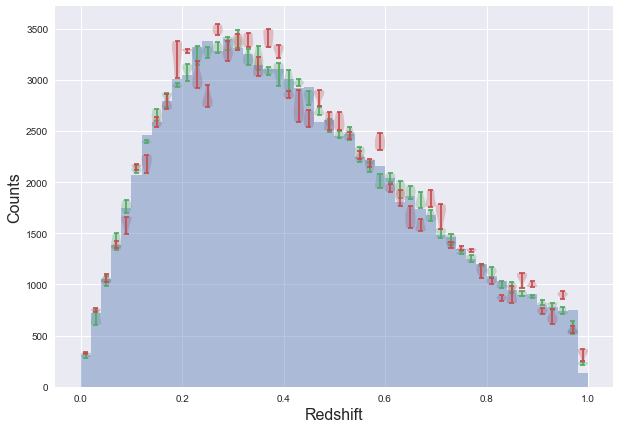

In [460]:
plt.figure(figsize=(10,7))
plt.hist(galaxies['z'], bins=z_bins, alpha=0.4, label='True')
plt.violinplot(z_nc, z_mdpt, widths=0.02, points=40)
plt.violinplot(z, z_mdpt, widths=0.02, points=40)
plt.xlabel('Redshift', fontsize=16)
plt.ylabel('Counts', fontsize=16)
#plt.legend()
plt.show()

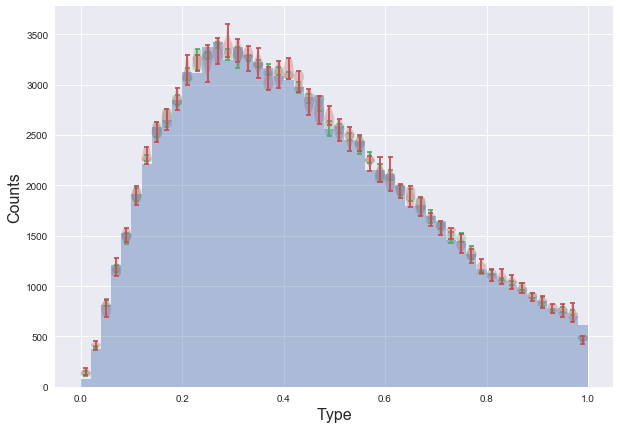

In [462]:
plt.figure(figsize=(10,7))
plt.hist(galaxies['t'], bins=t_bins, alpha=0.4, label='True')
plt.violinplot(t_nc, t_mdpt, widths=0.02, points=40)
plt.violinplot(t, t_mdpt, widths=0.02, points=40)
plt.xlabel('Type', fontsize=16)
plt.ylabel('Counts', fontsize=16)
#plt.legend()
plt.show()

## Look into how delta field is being sampled in the Gibbs sampler

Run everything up to 'Sample Features'

In [20]:
galaxies[:10]

<Table length=10>
         F                   t                   z          ... theta_y z_bin
      float64             float64             float64       ...  int64  int64
------------------- ------------------- ------------------- ... ------- -----
0.21130102618832666  0.2298286260787707  0.2098286260787707 ...     290    10
 0.2826099127290802  0.2815632411097654  0.3015632411097654 ...     674    15
 0.1356508755820287 0.11601895963920153 0.09601895963920153 ...     104     4
 0.5488402837070454  0.5411831982672924  0.5211831982672924 ...     598    26
 0.2828584033041508 0.24508901689792173 0.22508901689792174 ...     280    11
 0.4528357069976896 0.46748782134245453  0.4474878213424545 ...     911    22
0.05831136468318457 0.07684228681153586 0.05684228681153586 ...     672     2
 0.5366166191697334  0.5335911178900706  0.5135911178900706 ...     192    25
 0.5801084636059584  0.6217144029630128  0.6017144029630128 ...     149    30
  0.860414190158502  0.8914917196646338  0.9114917196646338 ...      86    45

Generate delta field

In [128]:
d_field = delta_field(nx, nz, rms=2.5)
rho_field = np.maximum(0, d_field + 1)

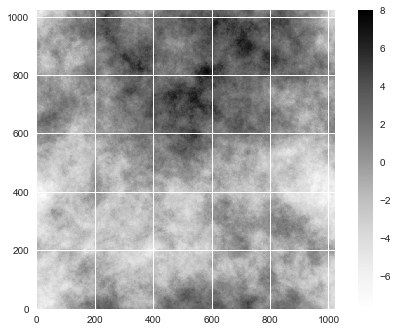

In [129]:
plt.imshow(d_field[:,:,0], origin='lower', interpolation='none')
plt.colorbar()
plt.show()

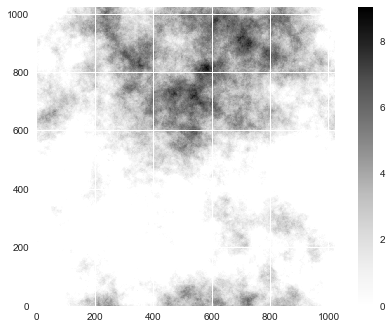

In [130]:
plt.imshow(rho_field[:,:,0], origin='lower', interpolation='none')
plt.colorbar()
plt.show()

In [133]:
z_indices = np.digitize(galaxies['z'], z_bins) - 1

In [135]:
np.max(z_indices)

49

In [137]:
rho_flat = rho_field.reshape(nx*nx, nz)

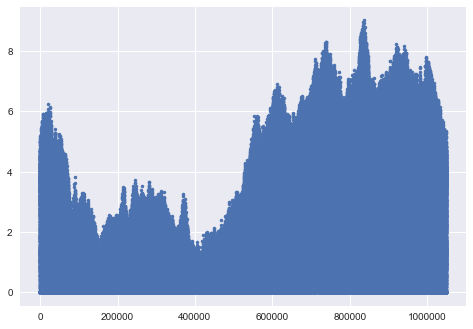

In [145]:
plt.plot(rho_flat[:,0], '.')
plt.show()

In [146]:
unique, counts = np.unique(z_indices, return_counts=True)
n_subsamples = (counts * 0.05).astype(int)

In [148]:
cdf = np.cumsum(rho_flat, axis=0)
cdf /= cdf[-1,:]

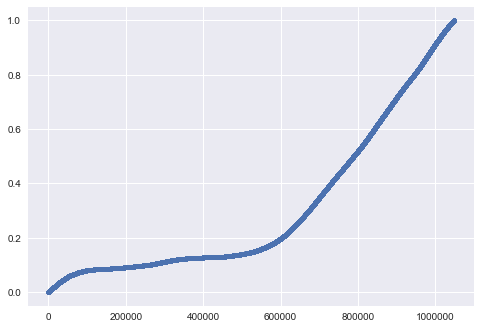

In [167]:
plt.plot(cdf[:,0], '.')
plt.show()

Look at first redshift slice:

In [153]:
u = rng.uniform(size=counts[0])

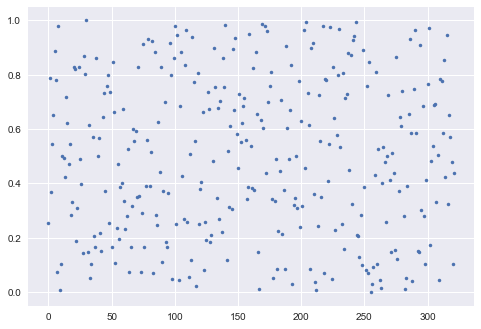

In [169]:
plt.plot(u, '.')
plt.show()

In [171]:
inv_transform_sample_indices = [np.argmin(np.abs(cdf[:,0] - u[j])) for j in range(counts[0])]

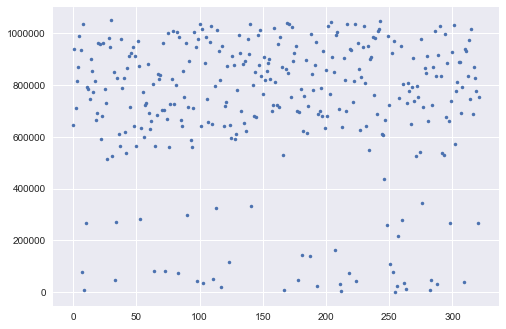

In [173]:
plt.plot(inv_transform_sample_indices, '.')
plt.show()

Matches well with plot of `rho_flat` above, with large peak at higher indices and lower peak at the smaller indices. Now we need to sample from the density field using the indices from the x-axis of the cdf.

In [323]:
ra_indices, dec_indices = np.unravel_index(inv_transform_sample_indices, (nx,nx))

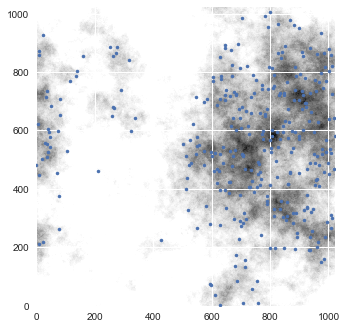

In [325]:
plt.imshow(rho_field[:,:,0].T, origin='lower', interpolation='none')
plt.plot(ra_indices, dec_indices, '.')
plt.show()

In [199]:
galaxies['z_bin'] = z_indices

Okay, sample features as well by running cell at the top of the notebook:

In [206]:
galaxies[:10]

<Table length=10>
         F                   t                   z          ... theta_y z_bin
      float64             float64             float64       ...  int64  int64
------------------- ------------------- ------------------- ... ------- -----
 0.5199894229486236  0.4729452941836346  0.4529452941836346 ...       0    22
0.15289664216304802  0.1410107041209204  0.1610107041209204 ...       0     8
 0.1766602232448429 0.16006533918192506 0.14006533918192507 ...       0     7
 0.5207239952162441  0.5198552012059569 0.49985520120595683 ...       0    24
0.33115861742673963 0.32226335451246385 0.30226335451246383 ...       0    15
0.31661413682452383 0.35863747399568213  0.3386374739956821 ...       0    16
 0.6832504149560417  0.6859364520580155  0.6659364520580154 ...       0    33
 0.6158879993468289  0.6281422006509958  0.6081422006509958 ...       0    30
0.49630431801696634  0.5138684118061275  0.4938684118061275 ...       0    24
 0.5533365435427994  0.5254317797568362  0.5054317797568362 ...       0    25

Save positions of 5% subsample of galaxies in each redshift slice to define density field:

In [217]:
for i in range(nz):
    u = rng.uniform(size=counts[i])
    ## this line takes the most time to run
    indices = [np.argmin(np.abs(cdf[:,i] - u[j])) for j in range(counts[i])]
    ix, iy = np.unravel_index(indices, (nx,nx))
    galaxies_index = np.argwhere(galaxies['z_bin'] == i)
    galaxies['theta_x'][galaxies_index] = ix.reshape(-1,1)
    galaxies['theta_y'][galaxies_index] = iy.reshape(-1,1)

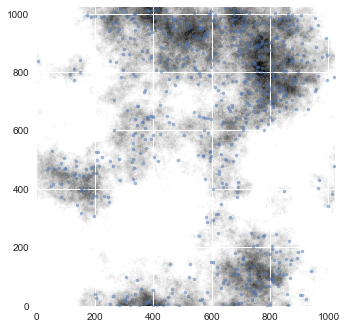

In [334]:
plt.imshow(rho_field[:,:,1].T,  origin='lower', interpolation='none')
plt.plot(galaxies[galaxies['z_bin'] == 1]['theta_x'], galaxies[galaxies['z_bin'] == 1]['theta_y'], '.', alpha=0.5)
plt.show()

In [570]:
np.std(galaxies['t']), np.std(galaxies['F']), np.std(features)

(0.23128440261105057, 0.23211067912218106, 0.23219603975869246)

In [640]:
new_sig = 0.3
new_features = feature_likelihood(galaxies['t'], scale=new_sig, rng=rng)

In [641]:
np.std(scipy.random.normal(loc=sampled_types[:100], scale=0.6))

0.6257177031318821

In [642]:
np.std(new_features), np.std(sampled_types)

(0.37934526681707065, 0.23128440261105057)

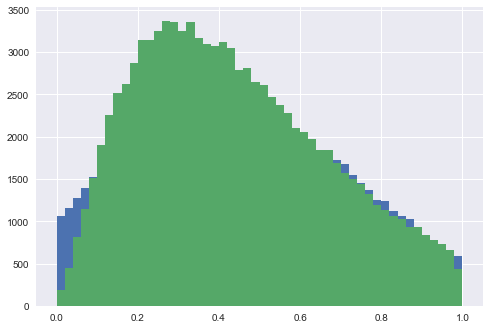

In [636]:
plt.hist(new_features, bins=t_bins)
plt.hist(galaxies['F'], bins=t_bins)
plt.show()

In [656]:
s = 0.02
new_is = np.empty(N, dtype=int)
for i in range(N):
    x = scipy.stats.norm.pdf(x=t_mdpt, loc=new_features[0], scale=s)
    ## make sure this has the same dimensions as dirichlet so that when we're sampling indices we 
    ## are sampling from a distribution of the same size (i.e. with redshift + type information, not
    ## just type information)
    x = np.full((nz,nt), x)
    x /= np.sum(x)
    new_i = scipy.stats.multinomial.rvs(n=1, p=x.flatten(), size=1, random_state=rng)
    new_is[i] = np.argmax(new_i)

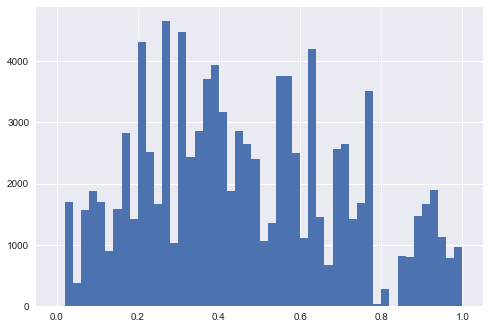

In [659]:
plt.hist(galaxies['t'][new_is], bins=t_bins)
plt.show()

### Now look at Gibbs sampler

In [68]:
def gibbs_sampler(seed, q, prior, initial_data=galaxies, sigma=sig_F, eps=1e-4, size=N, n_cycles=2500):
    
    rng = np.random.RandomState(seed=seed)
    
    z_samples = np.empty((n_cycles, size), dtype=np.float64)
    t_samples = np.empty((n_cycles, size), dtype=np.float64)
    
    new_z = initial_data['z']
    new_t = initial_data['t']
    
    for cycle in range(n_cycles):
        
        print('Cycle {} of {}'.format(cycle+1, n_cycles))
    
        ## Calculate probabilities
        h, _, _ = np.histogram2d(new_z, new_t, bins=(z_bins, t_bins))
                    
        h[h == 0] = eps
        alpha = h.flatten()

        ## Generate Dirichlet posterior for probabilities
        dirichlet = scipy.stats.dirichlet.rvs(alpha, random_state=rng, size=1)
        dirichlet = dirichlet.reshape(nz,nt)
        
        ## Sample from posterior
        new_indices = np.empty(size, dtype=int)
        
        
        if prior=='dirichlet':
            for k in range(size):
                probs = dirichlet 
                probs /= np.sum(probs)
                new_index = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=1, random_state=rng)
                new_indices[k] = np.argmax(new_index)
            
        elif prior=='feature':
            for k in range(size): 
                ## generate probabilities from a normal distribution centered on the feature value for that 
                ## galaxy
                #probs = scipy.stats.norm.pdf(x=t_mdpt, loc=initial_data['F'][k], scale=sigma)
                probs = scipy.stats.norm.pdf(x=t_mdpt, loc=new_features[k], scale=sigma)
                ## make sure this has the same dimensions as dirichlet so that when we're sampling indices we 
                ## are sampling from a distribution of the same size (i.e. with redshift + type information, not
                ## just type information)
                probs = np.full((nz,nt), probs)
                probs /= np.sum(probs)
                new_index = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=1, random_state=rng)
                new_indices[k] = np.argmax(new_index)
                    
        elif prior=='dirichlet_feature':
            for k in range(size): 
                norm = scipy.stats.norm.pdf(x=t_mdpt, loc=initial_data['F'][k], scale=sigma)
                probs = dirichlet * norm
                probs /= np.sum(probs)
                new_index = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=1, random_state=rng)
                new_indices[k] = np.argmax(new_index)
                
        elif prior=='all':
            for k in range(size): 
                norm = scipy.stats.norm.pdf(x=t_mdpt, loc=new_t[k], scale=sigma) 
                probs = dirichlet * norm * rho[initial_data['theta_x'][k], initial_data['theta_y'][k]].reshape(-1,1)
                probs /= np.sum(probs)
                new_index = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=1, random_state=rng)
                new_indices[k] = np.argmax(new_index)
                        
        new_iz, new_it = np.unravel_index(new_indices, (nz,nt))
        
        z_samples[cycle] = z_mdpt[new_iz]
        t_samples[cycle] = t_mdpt[new_it]
    
    np.save('z_samples_{}_{}'.format(prior, seed), z_samples)
    np.save('t_samples_{}_{}'.format(prior, seed), t_samples)
    
    q.put([z_bins, z_mdpt, t_bins, t_mdpt, rho, galaxies])
    #return(z_samples, t_samples)

In [302]:
z_d, t_d = gibbs_sampler(galaxies, 123, n_cycles=5, prior='dirichlet')

Cycle 1 of 5
Cycle 2 of 5
Cycle 3 of 5
Cycle 4 of 5
Cycle 5 of 5


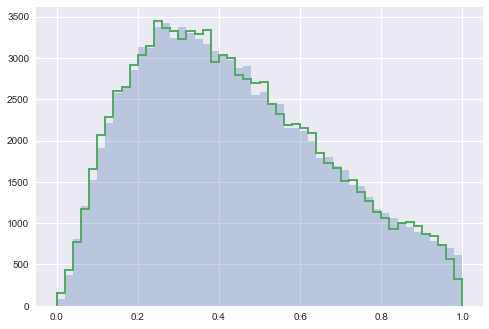

In [317]:
plt.hist(galaxies['t'], bins=t_bins, alpha=0.3)
plt.hist(t_d[-1], bins=t_bins, histtype='step', lw=2)
plt.show()

0.3263265131140647


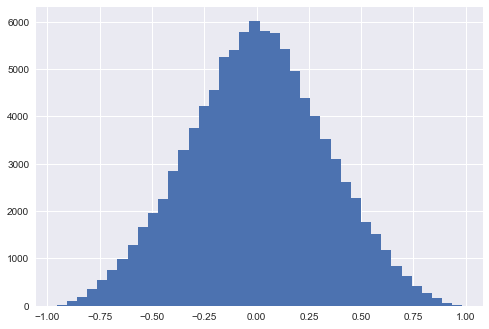

In [332]:
samples = galaxies['F'] - t_d[-1]
print(np.std(samples))
plt.hist(samples, bins=40)
plt.show()

In [275]:
nn = scipy.stats.norm.pdf(x=t_mdpt, loc=galaxies['t'][10], scale=sig_F)

In [291]:
np.testing.assert_almost_equal(np.mean(nn * t_mdpt), galaxies['t'][10], decimal=7)
np.testing.assert_almost_equal(np.sum(nn * (t_mdpt - galaxies['t'][10]) ** 2), sig_F, decimal=7)

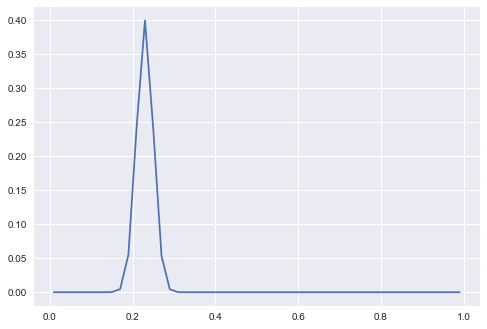

In [266]:
plt.plot(t_mdpt, np.diff(t_mdpt)[0] * nn)
plt.show()

In [267]:
nn /= np.sum(nn)

In [239]:
n_rvs = scipy.stats.norm.rvs(loc=galaxies['t'][0], scale=sig_F, size=nt, random_state=rng)

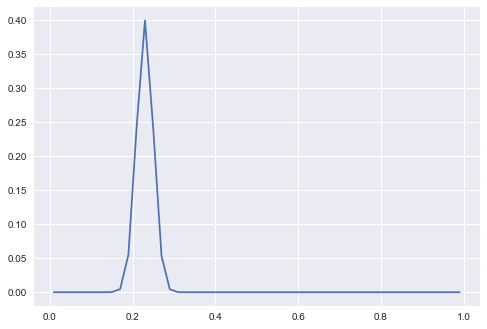

In [268]:
plt.plot(t_mdpt, nn)
plt.show()

In [241]:
np.mean(nn), np.std(nn)

(0.02, 1.1997580987571031e-05)

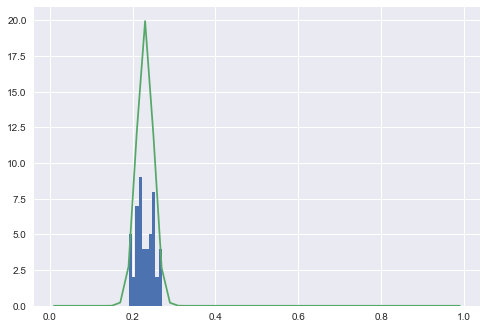

In [245]:
plt.hist(n_rvs)
plt.plot(t_mdpt, nn)
plt.show()

In [196]:
## nn is normalized
np.sum(nn * np.diff(t_bins)[0])

1.0000000053428235

In [199]:
np.sum(nn/np.sum(nn))

1.0

In [356]:
z_f, t_f = gibbs_sampler(galaxies, 123, n_cycles=2, prior='feature')

Cycle 1 of 2
Cycle 2 of 2


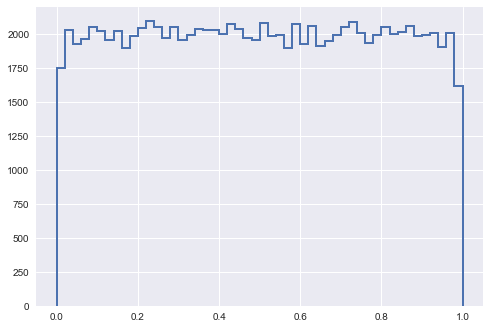

In [353]:
plt.hist(z_f[-1], bins=t_bins, histtype='step', lw=2)
plt.show()

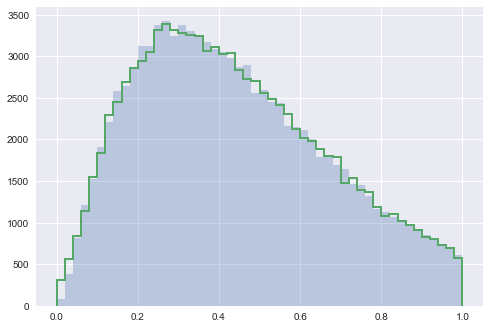

In [357]:
plt.hist(galaxies['t'], bins=t_bins, alpha=0.3)
plt.hist(t_f[-1], bins=t_bins, histtype='step', lw=2)
plt.show()

In [318]:
np.testing.assert_almost_equal(np.mean(t_d[-1]), np.mean(galaxies['t']), decimal=2)
np.testing.assert_almost_equal(np.std(t_d[-1]), np.std(galaxies['t']), decimal=2)

In [319]:
np.testing.assert_almost_equal(np.mean(t_f[-1]), np.mean(galaxies['t']), decimal=2)
np.testing.assert_almost_equal(np.std(t_f[-1]), np.std(galaxies['t']), decimal=2)

In [320]:
np.testing.assert_almost_equal(np.mean(t_df[-1]), np.mean(galaxies['t']), decimal=2)
np.testing.assert_almost_equal(np.std(t_df[-1]), np.std(galaxies['t']), decimal=2)

Great - this works now. Sampling just based on the feature likelihood recovers the standard deviation of the feature distribution we originally generated:

0.02234622321831698


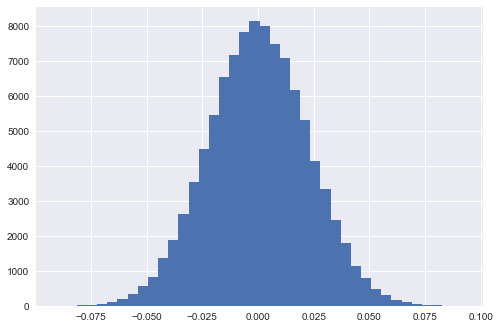

In [364]:
samples = galaxies['F'] - t_f[-1]
print(np.std(samples))
plt.hist(samples, bins=40)
plt.show()

In [360]:
z_df, t_df = gibbs_sampler(galaxies, 123, n_cycles=1, prior='dirichlet_feature')

Cycle 1 of 1


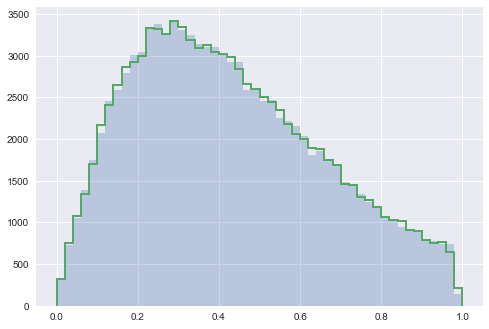

In [361]:
plt.hist(galaxies['z'], bins=z_bins, alpha=0.3)
plt.hist(z_df[-1], bins=z_bins, histtype='step', lw=2)
plt.show()

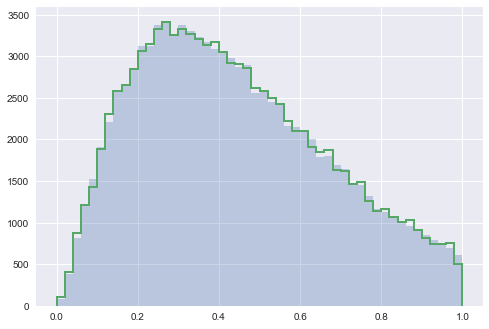

In [362]:
plt.hist(galaxies['t'], bins=t_bins, alpha=0.3)
plt.hist(t_df[-1], bins=t_bins, histtype='step', lw=2)
plt.show()

In [425]:
bin_edges = np.linspace(-0.1,0.1,51)
y_points = np.arange(0,7500)

In [485]:
np.std(galaxies['F'])

0.23211067912218106

In [486]:
sig_F

0.02

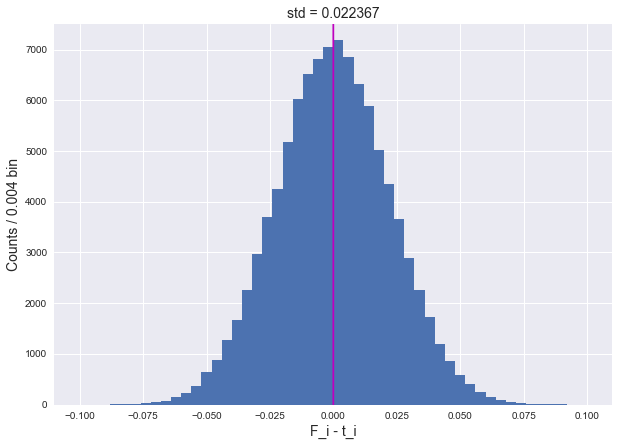

In [427]:
samples = galaxies['F'] - t_df[-1]
#print(np.std(samples))
plt.figure(figsize=(10,7))
plt.hist(samples, bins=bin_edges)
plt.plot(np.repeat(0, len(y_points)), y_points, 'm')
plt.xlabel('F_i - t_i', fontsize=14)
plt.ylabel('Counts / {:.3f} bin'.format(np.diff(bin_edges)[-1]), fontsize=14)
plt.title('std = {:2f}'.format(np.std(samples)), fontsize=14)
plt.ylim(0,7500)
plt.show()

0.02236650585260103


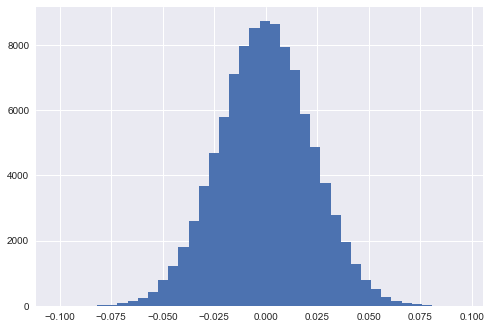

In [363]:
samples = galaxies['F'] - t_df[-1]
print(np.std(samples))
plt.hist(samples, bins=40)
plt.show()

In [326]:
z_a, t_a = gibbs_sampler(galaxies, 123, n_cycles=5, prior='all')

Cycle 1 of 5
Cycle 2 of 5
Cycle 3 of 5
Cycle 4 of 5
Cycle 5 of 5


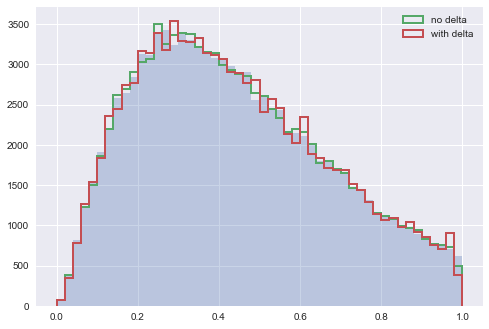

In [338]:
plt.hist(galaxies['t'], bins=t_bins, alpha=0.3)
plt.hist(t_df[0], bins=t_bins, histtype='step', lw=2, label='no delta')
plt.hist(t_a[0], bins=t_bins, histtype='step', lw=2, label='with delta')
plt.legend()
plt.show()

0.053223731270164915


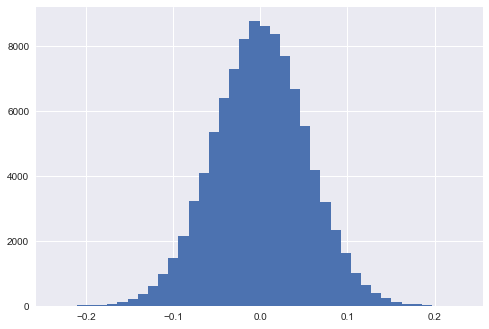

In [333]:
samples = galaxies['F'] - t_a[-1]
print(np.std(samples))
plt.hist(samples, bins=40)
plt.show()

#### Now that we know that sampling from the Dirichlet and feature distributions is being correctly implemented, try and trace down the issue of why the sampling errors from the Dirichlet + feature posterior are so small.

## Dirichlet only

In [66]:
z_hist_22, t_hist_22 = get_hist_data('z_samples_dirichlet_22.npy', 't_samples_dirichlet_22.npy')
z_hist_33, t_hist_33 = get_hist_data('z_samples_dirichlet_33.npy', 't_samples_dirichlet_33.npy')
z_hist_44, t_hist_44 = get_hist_data('z_samples_dirichlet_44.npy', 't_samples_dirichlet_44.npy')
z_hist_55, t_hist_55 = get_hist_data('z_samples_dirichlet_55.npy', 't_samples_dirichlet_55.npy')

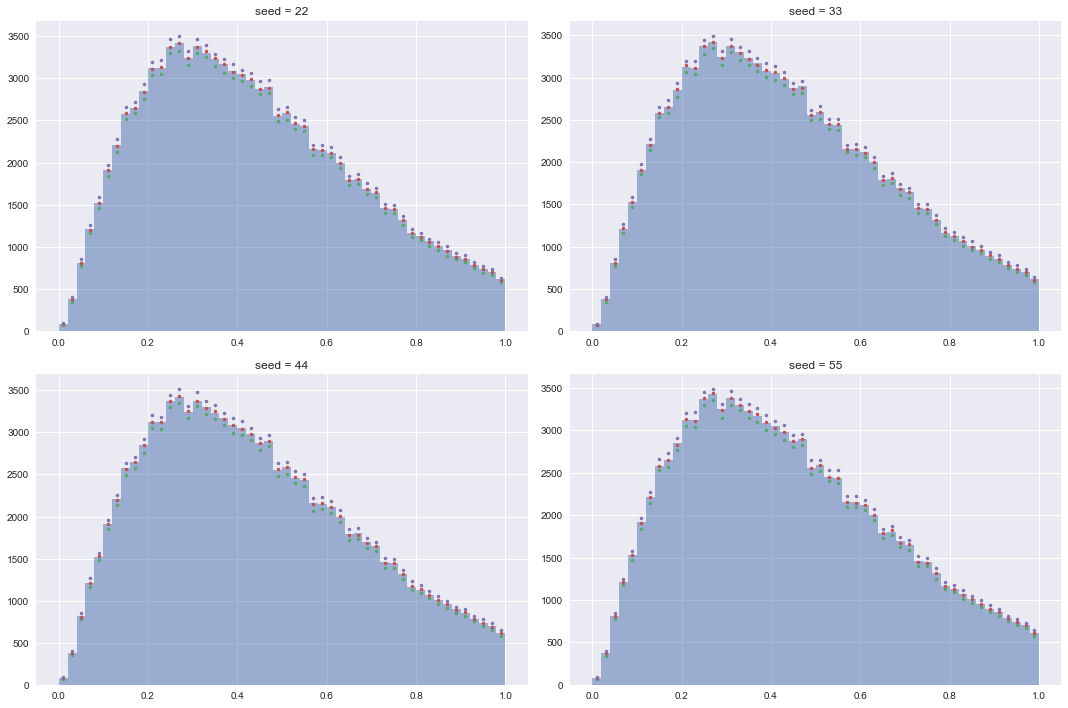

In [67]:
t_percentile_22 = np.percentile(t_hist_22, (16, 50, 84), axis=0)
t_percentile_33 = np.percentile(t_hist_33, (16, 50, 84), axis=0)
t_percentile_44 = np.percentile(t_hist_44, (16, 50, 84), axis=0)
t_percentile_55 = np.percentile(t_hist_55, (16, 50, 84), axis=0)


fig, axs = plt.subplots(2,2, figsize=(15,10))
axs = axs.ravel()

axs[0].hist(galaxies['t'], bins=t_bins, alpha=0.5)
axs[0].plot(t_mdpt, t_percentile_22[0,:], '.')
axs[0].plot(t_mdpt, t_percentile_22[1,:], '.')
axs[0].plot(t_mdpt, t_percentile_22[2,:], '.')
axs[0].set_title('seed = 22')

axs[1].hist(galaxies['t'], bins=t_bins, alpha=0.5)
axs[1].plot(t_mdpt, t_percentile_33[0,:], '.')
axs[1].plot(t_mdpt, t_percentile_33[1,:], '.')
axs[1].plot(t_mdpt, t_percentile_33[2,:], '.')
axs[1].set_title('seed = 33')

axs[2].hist(galaxies['t'], bins=t_bins, alpha=0.5)
axs[2].plot(t_mdpt, t_percentile_44[0,:], '.')
axs[2].plot(t_mdpt, t_percentile_44[1,:], '.')
axs[2].plot(t_mdpt, t_percentile_44[2,:], '.')
axs[2].set_title('seed = 44')

axs[3].hist(galaxies['t'], bins=t_bins, alpha=0.5)
axs[3].plot(t_mdpt, t_percentile_55[0,:], '.')
axs[3].plot(t_mdpt, t_percentile_55[1,:], '.')
axs[3].plot(t_mdpt, t_percentile_55[2,:], '.')
axs[3].set_title('seed = 55')


plt.tight_layout()
plt.show()

## Feature likelihood

In [645]:
z_hist_feature_22, t_hist_feature_22 = get_hist_data('z_samples_feature_22.npy', 't_samples_feature_22.npy')
z_hist_feature_33, t_hist_feature_33 = get_hist_data('z_samples_feature_33.npy', 't_samples_feature_33.npy')
z_hist_feature_44, t_hist_feature_44 = get_hist_data('z_samples_feature_44.npy', 't_samples_feature_44.npy')
z_hist_feature_55, t_hist_feature_55 = get_hist_data('z_samples_feature_55.npy', 't_samples_feature_55.npy')

In [646]:
np.std(new_features - np.load('t_samples_feature_22.npy')[-1])

0.28635465685838457

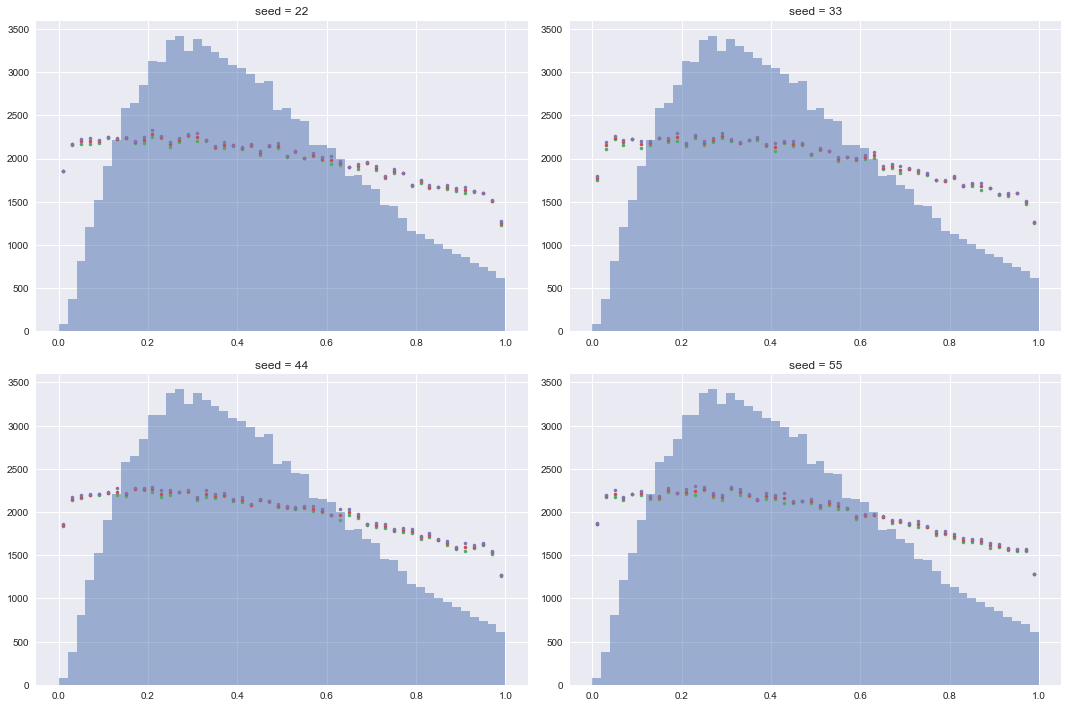

In [647]:
t_percentile_feature_22 = np.percentile(t_hist_feature_22, (16, 50, 84), axis=0)
t_percentile_feature_33 = np.percentile(t_hist_feature_33, (16, 50, 84), axis=0)
t_percentile_feature_44 = np.percentile(t_hist_feature_44, (16, 50, 84), axis=0)
t_percentile_feature_55 = np.percentile(t_hist_feature_55, (16, 50, 84), axis=0)


fig, axs = plt.subplots(2,2, figsize=(15,10))
axs = axs.ravel()

axs[0].hist(galaxies['t'], bins=t_bins, alpha=0.5)
axs[0].plot(t_mdpt, t_percentile_feature_22[0,:], '.')
axs[0].plot(t_mdpt, t_percentile_feature_22[1,:], '.')
axs[0].plot(t_mdpt, t_percentile_feature_22[2,:], '.')
axs[0].set_title('seed = 22')

axs[1].hist(galaxies['t'], bins=t_bins, alpha=0.5)
axs[1].plot(t_mdpt, t_percentile_feature_33[0,:], '.')
axs[1].plot(t_mdpt, t_percentile_feature_33[1,:], '.')
axs[1].plot(t_mdpt, t_percentile_feature_33[2,:], '.')
axs[1].set_title('seed = 33')

axs[2].hist(galaxies['t'], bins=t_bins, alpha=0.5)
axs[2].plot(t_mdpt, t_percentile_feature_44[0,:], '.')
axs[2].plot(t_mdpt, t_percentile_feature_44[1,:], '.')
axs[2].plot(t_mdpt, t_percentile_feature_44[2,:], '.')
axs[2].set_title('seed = 44')

axs[3].hist(galaxies['t'], bins=t_bins, alpha=0.5)
axs[3].plot(t_mdpt, t_percentile_feature_55[0,:], '.')
axs[3].plot(t_mdpt, t_percentile_feature_55[1,:], '.')
axs[3].plot(t_mdpt, t_percentile_feature_55[2,:], '.')
axs[3].set_title('seed = 55')


plt.tight_layout()
plt.show()

## Dirichlet + feature likelihood

In [76]:
z_hist_dirichlet_feature_22, t_hist_dirichlet_feature_22 = get_hist_data('z_samples_dirichlet_feature_22.npy', 't_samples_dirichlet_feature_22.npy')
z_hist_dirichlet_feature_33, t_hist_dirichlet_feature_33 = get_hist_data('z_samples_dirichlet_feature_33.npy', 't_samples_dirichlet_feature_33.npy')
z_hist_dirichlet_feature_44, t_hist_dirichlet_feature_44 = get_hist_data('z_samples_dirichlet_feature_44.npy', 't_samples_dirichlet_feature_44.npy')
z_hist_dirichlet_feature_55, t_hist_dirichlet_feature_55 = get_hist_data('z_samples_dirichlet_feature_55.npy', 't_samples_dirichlet_feature_55.npy')

In [77]:
len(z_hist_dirichlet_feature_22)

2500

In [78]:
np.std(galaxies['F'] - np.load('t_samples_dirichlet_feature_22.npy')[-1])

0.020084740889650655

In [79]:
np.std(np.load('t_samples_dirichlet_feature_22.npy')[-1]), np.std(galaxies['F'])

(0.231178431799422, 0.23211067912218106)

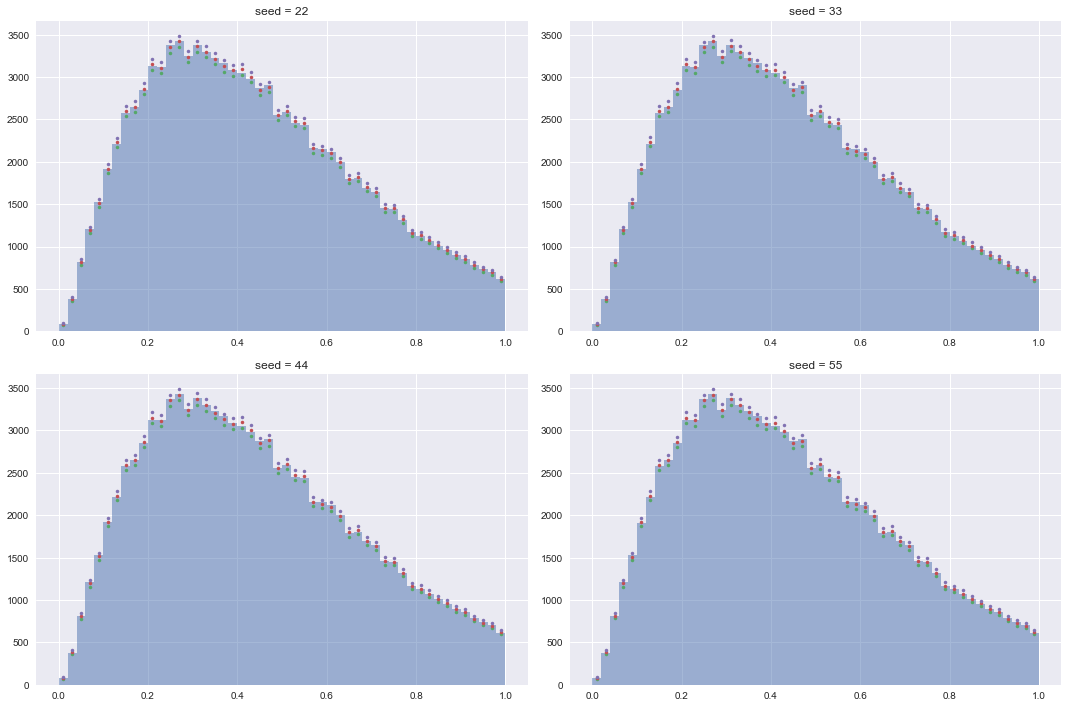

In [81]:
t_percentile_dirichlet_feature_22 = np.percentile(t_hist_dirichlet_feature_22, (16, 50, 84), axis=0)
t_percentile_dirichlet_feature_33 = np.percentile(t_hist_dirichlet_feature_33, (16, 50, 84), axis=0)
t_percentile_dirichlet_feature_44 = np.percentile(t_hist_dirichlet_feature_44, (16, 50, 84), axis=0)
t_percentile_dirichlet_feature_55 = np.percentile(t_hist_dirichlet_feature_55, (16, 50, 84), axis=0)


fig, axs = plt.subplots(2,2, figsize=(15,10))
axs = axs.ravel()

axs[0].hist(galaxies['t'], bins=t_bins, alpha=0.5)
axs[0].plot(t_mdpt, t_percentile_dirichlet_feature_22[0,:], '.')
axs[0].plot(t_mdpt, t_percentile_dirichlet_feature_22[1,:], '.')
axs[0].plot(t_mdpt, t_percentile_dirichlet_feature_22[2,:], '.')
axs[0].set_title('seed = 22')

axs[1].hist(galaxies['t'], bins=t_bins, alpha=0.5)
axs[1].plot(t_mdpt, t_percentile_dirichlet_feature_33[0,:], '.')
axs[1].plot(t_mdpt, t_percentile_dirichlet_feature_33[1,:], '.')
axs[1].plot(t_mdpt, t_percentile_dirichlet_feature_33[2,:], '.')
axs[1].set_title('seed = 33')

axs[2].hist(galaxies['t'], bins=t_bins, alpha=0.5)
axs[2].plot(t_mdpt, t_percentile_dirichlet_feature_44[0,:], '.')
axs[2].plot(t_mdpt, t_percentile_dirichlet_feature_44[1,:], '.')
axs[2].plot(t_mdpt, t_percentile_dirichlet_feature_44[2,:], '.')
axs[2].set_title('seed = 44')

axs[3].hist(galaxies['t'], bins=t_bins, alpha=0.5)
axs[3].plot(t_mdpt, t_percentile_dirichlet_feature_55[0,:], '.')
axs[3].plot(t_mdpt, t_percentile_dirichlet_feature_55[1,:], '.')
axs[3].plot(t_mdpt, t_percentile_dirichlet_feature_55[2,:], '.')
axs[3].set_title('seed = 55')


plt.tight_layout()
plt.show()

In [135]:
def gibbs_sampler2(seed, prior, initial_data=galaxies, sigma=sig_F, eps=1e-4, size=N, n_cycles=2500):
    
    rng = np.random.RandomState(seed=seed)
    
    z_samples = np.empty((n_cycles, size), dtype=np.float64)
    t_samples = np.empty((n_cycles, size), dtype=np.float64)
    
    new_z = initial_data['z']
    new_t = initial_data['t']
    
    for cycle in range(n_cycles):
        
        print('Cycle {} of {}'.format(cycle+1, n_cycles))
    
        ## Calculate probabilities
        h, _, _ = np.histogram2d(new_z[::20], new_t[::20], bins=(z_bins, t_bins))
                    
        h[h == 0] = eps
        alpha = h.flatten()

        ## Generate Dirichlet posterior for probabilities
        dirichlet = scipy.stats.dirichlet.rvs(alpha, random_state=rng, size=1)
        dirichlet = dirichlet.reshape(nz,nt)
        
        ## Sample from posterior
        new_indices = np.empty(size, dtype=int)
        
        
        if prior=='dirichlet':
            for k in range(size):
                probs = dirichlet 
                probs /= np.sum(probs)
                new_index = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=1, random_state=rng)
                new_indices[k] = np.argmax(new_index)
            
        elif prior=='feature':
            for k in range(size): 
                ## generate probabilities from a normal distribution centered on the feature value for that 
                ## galaxy
                #probs = scipy.stats.norm.pdf(x=t_mdpt, loc=initial_data['F'][k], scale=sigma)
                probs = scipy.stats.norm.pdf(x=t_mdpt, loc=new_features[k], scale=sigma)
                ## make sure this has the same dimensions as dirichlet so that when we're sampling indices we 
                ## are sampling from a distribution of the same size (i.e. with redshift + type information, not
                ## just type information)
                probs = np.full((nz,nt), probs)
                probs /= np.sum(probs)
                new_index = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=1, random_state=rng)
                new_indices[k] = np.argmax(new_index)
                    
        elif prior=='dirichlet_feature':
            for k in range(size): 
                norm = scipy.stats.norm.pdf(x=t_mdpt, loc=initial_data['F'][k], scale=sigma)
                probs = dirichlet * norm
                probs /= np.sum(probs)
                new_index = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=1, random_state=rng)
                new_indices[k] = np.argmax(new_index)
                
        elif prior=='all':
            for k in range(size): 
                norm = scipy.stats.norm.pdf(x=t_mdpt, loc=new_t[k], scale=sigma) 
                probs = dirichlet * norm * rho[initial_data['theta_x'][k], initial_data['theta_y'][k]].reshape(-1,1)
                probs /= np.sum(probs)
                new_index = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=1, random_state=rng)
                new_indices[k] = np.argmax(new_index)
                        
        new_iz, new_it = np.unravel_index(new_indices, (nz,nt))
        
        z_samples[cycle] = z_mdpt[new_iz]
        t_samples[cycle] = t_mdpt[new_it]
    
    #np.save('z_samples_{}_{}'.format(prior, seed), z_samples)
    #np.save('t_samples_{}_{}'.format(prior, seed), t_samples)
    
    return(z_samples, t_samples)

In [126]:
z_t_d = np.empty((500,nz), dtype=int) 
t_t_d = np.empty((500,nt), dtype=int)

for i in range(500):
    z_t_d[i], _ = np.histogram(z_test[i], bins=z_bins)
    t_t_d[i], _ = np.histogram(t_test[i], bins=t_bins)

In [127]:
z_t = np.empty((500,nz), dtype=int) 
t_t = np.empty((500,nt), dtype=int)

for i in range(500):
    z_t[i], _ = np.histogram(z_test[i], bins=z_bins)
    t_t[i], _ = np.histogram(t_test[i], bins=t_bins)

In [128]:
z_t_all = np.empty((500,nz), dtype=int) 
t_t_all = np.empty((500,nt), dtype=int)

for i in range(500):
    z_t_all[i], _ = np.histogram(z_test_all[i], bins=z_bins)
    t_t_all[i], _ = np.histogram(t_test_all[i], bins=t_bins)

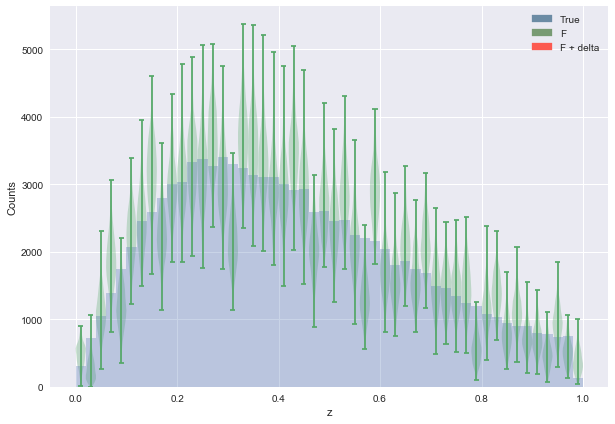

In [129]:
blue = sns.xkcd_rgb["grey blue"]
red = sns.xkcd_rgb["coral"]
green = sns.xkcd_rgb["grey green"]


blue_patch = patches.Patch(color=blue)
red_patch = patches.Patch(color=red)
green_patch = patches.Patch(color=green)

plt.figure(figsize=(10,7))
ax = plt.subplot(111)
plt.hist(galaxies['z'], bins=z_bins, alpha=0.3)
plt.violinplot(z_t_d, z_mdpt, widths=0.02, points=20)
plt.xlabel('z')
plt.ylabel('Counts')
ax.legend([blue_patch, green_patch, red_patch], ['True', 'F', 'F + delta'])
plt.show()

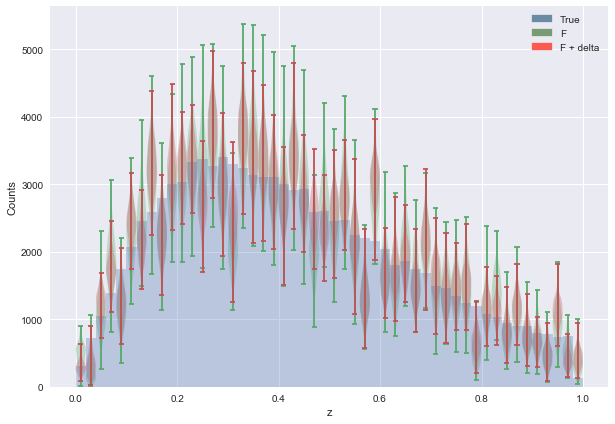

In [130]:
blue = sns.xkcd_rgb["grey blue"]
red = sns.xkcd_rgb["coral"]
green = sns.xkcd_rgb["grey green"]


blue_patch = patches.Patch(color=blue)
red_patch = patches.Patch(color=red)
green_patch = patches.Patch(color=green)

plt.figure(figsize=(10,7))
ax = plt.subplot(111)
plt.hist(galaxies['z'], bins=z_bins, alpha=0.3)
plt.violinplot(z_t, z_mdpt, widths=0.02, points=20)
plt.violinplot(z_t_all, z_mdpt, widths=0.02, points=20)
plt.xlabel('z')
plt.ylabel('Counts')
ax.legend([blue_patch, green_patch, red_patch], ['True', 'F', 'F + delta'])
plt.show()

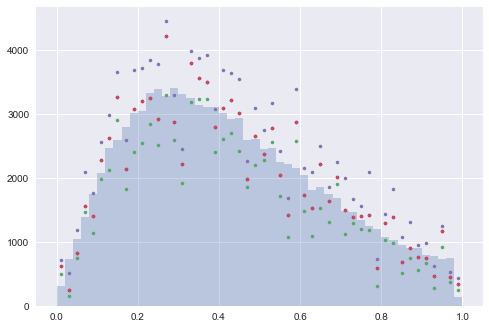

In [103]:
plt.hist(galaxies['z'], bins=z_bins, alpha=0.3)
plt.plot(z_mdpt, np.median(z_t, axis=0), '.', c='m', lw=2)
plt.plot(z_mdpt, z_percentile_test[0,:], '.')
plt.plot(z_mdpt, z_percentile_test[1,:], '.')
plt.plot(z_mdpt, z_percentile_test[2,:], '.')
plt.show()

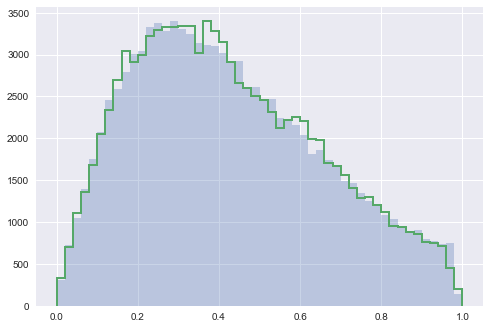

In [79]:
## Dirichlet and flux likelihood and delta field
plt.hist(galaxies['z'], bins=z_bins, alpha=0.3)
plt.hist(z_test[-1], bins=z_bins, histtype='step', lw=2)
plt.show()

In [98]:
z = np.empty((len(z_test),nz), dtype=int)
for j in range(len(z_test)):
    z[j], _ = np.histogram(z_test[j], bins=z_bins)

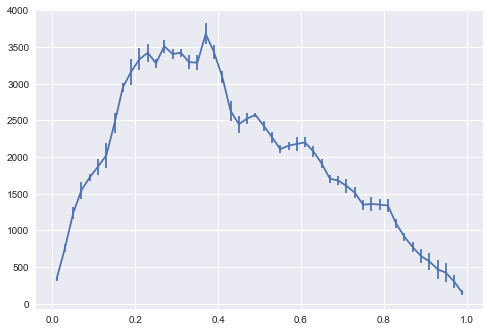

In [99]:
plt.errorbar(z_mdpt, np.mean(z, axis=0), yerr=np.std(z, axis=0))
plt.show()

In [100]:
z_nc = np.empty((len(z_test_nc),nz), dtype=int)
for j in range(len(z_test_nc)):
    z_nc[j], _ = np.histogram(z_test_nc[j], bins=z_bins)

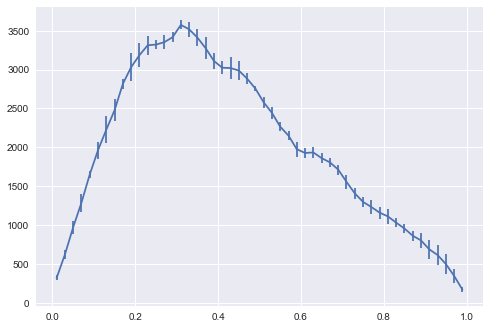

In [101]:
plt.errorbar(z_mdpt, np.mean(z_nc, axis=0), yerr=np.std(z, axis=0))
plt.show()

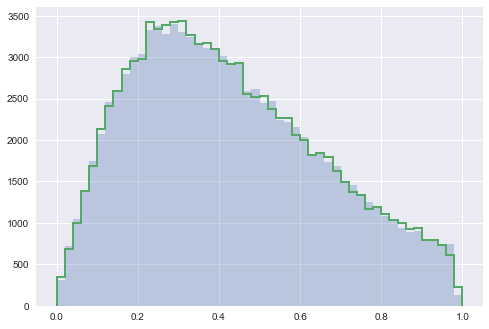

In [48]:
## Dirichlet only
plt.hist(galaxies['z'], bins=z_bins, alpha=0.3)
plt.hist(z_test[-1], bins=z_bins, histtype='step', lw=2)
plt.show()

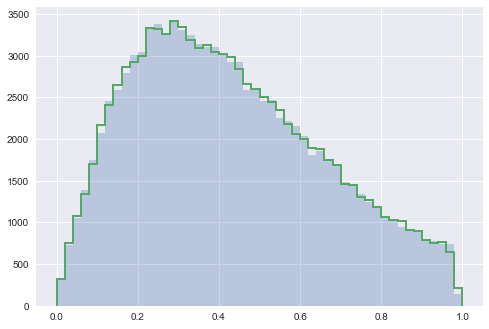

In [50]:
## Dirichlet and flux likelihood
plt.hist(galaxies['z'], bins=z_bins, alpha=0.3)
plt.hist(z_test[-1], bins=z_bins, histtype='step', lw=2)
plt.show()

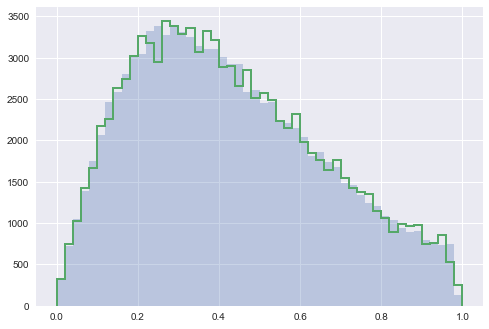

In [56]:
## Dirichlet and flux likelihood and delta field
plt.hist(galaxies['z'], bins=z_bins, alpha=0.3)
plt.hist(z_test[-1], bins=z_bins, histtype='step', lw=2)
plt.show()

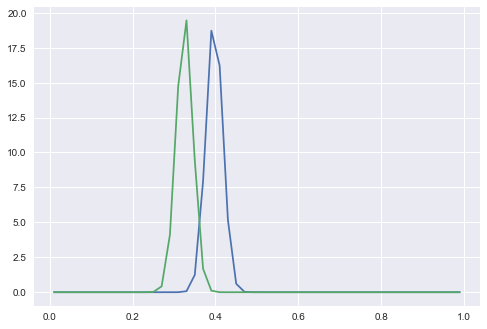

In [62]:
norm = scipy.stats.norm.pdf(t_mdpt, loc=galaxies['F'][1000], scale=sig_F) 
norm10 = scipy.stats.norm.pdf(t_mdpt, loc=galaxies['F'][10], scale=sig_F) 
plt.plot(t_mdpt, norm)
plt.plot(t_mdpt, norm10)
plt.show()

In [63]:
norm.shape

(50,)

In [64]:
h, _, _ = np.histogram2d(galaxies['z'], galaxies['t'], bins=(z_bins, t_bins))

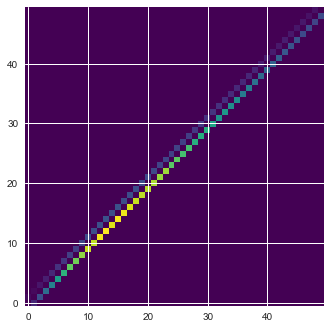

In [65]:
plt.imshow(h, cmap='viridis', origin='lower')
plt.show()

In [66]:
h[h == 0] = 0.000001
alpha = h.flatten()

## Generate Dirichlet posterior for probabilities
dirichlet = scipy.stats.dirichlet.rvs(alpha, random_state=rng, size=1)
dirichlet = dirichlet.reshape(nz,nt)

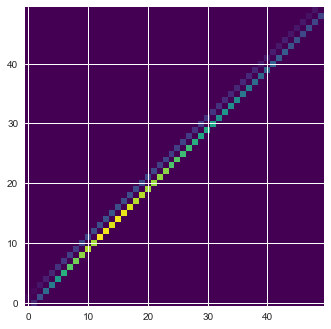

In [67]:
plt.imshow(dirichlet, cmap='viridis', origin='lower')
plt.show()

In [68]:
dirichlet.shape

(50, 50)

In [71]:
i = 90000
norm = scipy.stats.norm.pdf(t_mdpt, loc=galaxies['F'][i], scale=sig_F) 
#Probability of ra,dec position in each z slice
#delta = rho[galaxies['theta_x'][i], galaxies['theta_y'][i]]

In [73]:
dirichlet.shape, norm.shape, rho.shape

((50, 50), (50,), (1024, 1024, 50))

In [420]:
posterior = dirichlet * norm #* delta

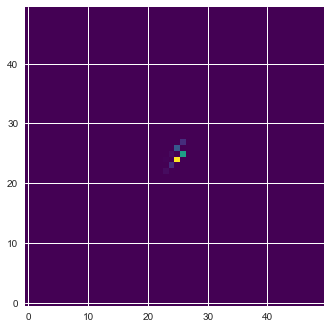

In [387]:
#i = 0
plt.imshow(posterior, cmap='viridis', origin='lower')
plt.show()

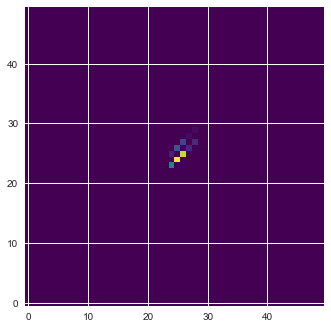

In [394]:
#i = 50
plt.imshow(posterior, cmap='viridis', origin='lower')
plt.show()

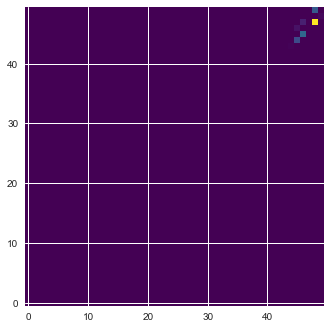

In [391]:
#i = 1000
plt.imshow(posterior, cmap='viridis', origin='lower')
plt.show()

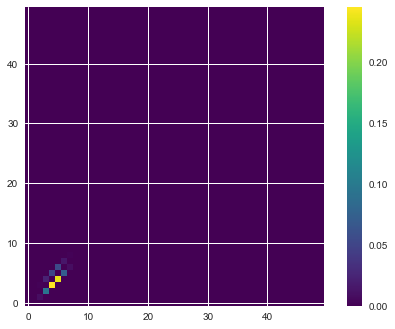

In [421]:
#i = 90000
plt.imshow(posterior, cmap='viridis', origin='lower')
plt.colorbar()
plt.show()

In [422]:
posterior /= np.sum(posterior)
new_index = scipy.stats.multinomial.rvs(n=1, p=posterior.flatten(), size=1, random_state=rng)
new_index= np.argmax(new_index)

In [423]:
new_iz, new_it = np.unravel_index(new_index, (nz,nt))
        
new_z = scipy.stats.norm.rvs(loc=z_mdpt[new_iz], scale=0.01, random_state=rng)
new_t = scipy.stats.norm.rvs(loc=t_mdpt[new_it], scale=0.01, random_state=rng)

In [425]:
new_z, new_t

(0.07130262627296682, 0.09936118083884263)

In [427]:
galaxies['z'][i], galaxies['t'][i]

(0.06518032536842133, 0.08518032536842134)

In [247]:
z_samples_nc, t_samples_nc = gibbs_sampler(galaxies, seed=123, clustering=False)

Cycle 1 of 3
Cycle 2 of 3
Cycle 3 of 3


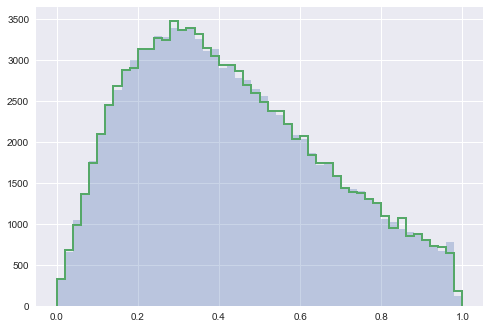

In [248]:
plt.hist(galaxies['z'], bins=z_bins, alpha=0.3)
plt.hist(z_samples_nc[0], bins=z_bins, histtype='step', lw=2)
plt.show()

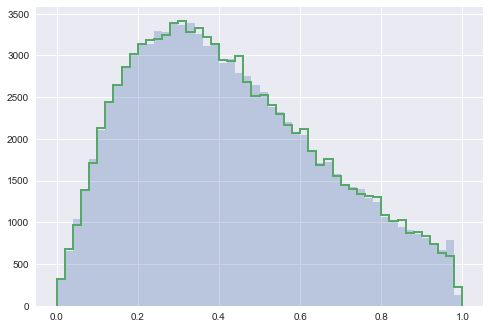

In [249]:
plt.hist(galaxies['z'], bins=z_bins, alpha=0.3)
plt.hist(z_samples_nc[1], bins=z_bins, histtype='step', lw=2)
plt.show()

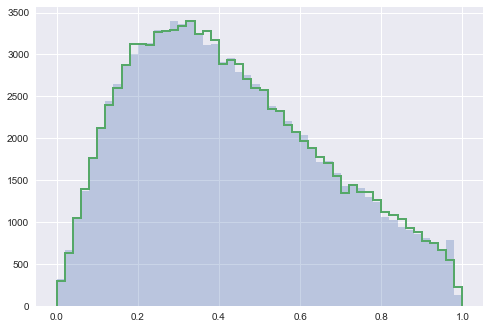

In [250]:
plt.hist(galaxies['z'], bins=z_bins, alpha=0.3)
plt.hist(z_samples_nc[-1], bins=z_bins, histtype='step', lw=2)
plt.show()

In [251]:
z_samples, t_samples = gibbs_sampler(galaxies, seed=123)

Cycle 1 of 3
Cycle 2 of 3
Cycle 3 of 3


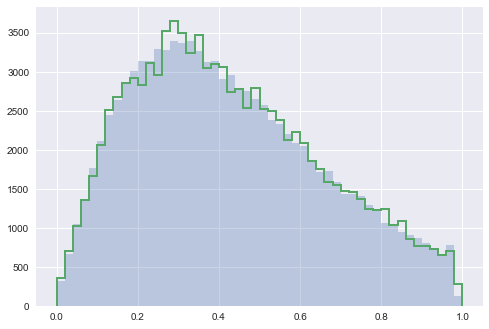

In [255]:
plt.hist(galaxies['z'], bins=z_bins, alpha=0.3)
plt.hist(z_samples[0], bins=z_bins, histtype='step', lw=2)
plt.show()

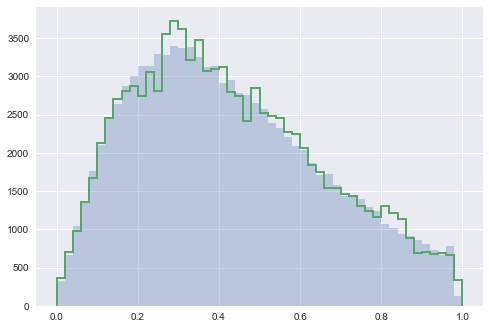

In [256]:
plt.hist(galaxies['z'], bins=z_bins, alpha=0.3)
plt.hist(z_samples[1], bins=z_bins, histtype='step', lw=2)
plt.show()

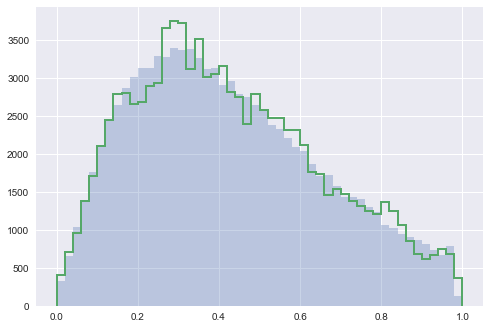

In [257]:
plt.hist(galaxies['z'], bins=z_bins, alpha=0.3)
plt.hist(z_samples[-1], bins=z_bins, histtype='step', lw=2)
plt.show()